<a href="https://colab.research.google.com/github/izakaes-beep/Data-Analytics-Assessment/blob/main/Group_A_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymatgen matminer dscribe ase mp-api tqdm xgboost scikit-learn seaborn pandas matplotlib plotly catboost torch

# **0. Requirements**
Before everything begins, check and load every package once and for all.

In [ ]:
import warnings
import random
import math
import copy
import pickle
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_val_score

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from mp_api.client import MPRester
from collections import Counter

from matminer.datasets import load_dataset, get_all_dataset_info
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import SiteStatsFingerprint
from matminer.featurizers.conversions import StrToComposition
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from pymatgen.core import Composition, Structure

warnings.filterwarnings("ignore")  ##ignore warnings during featurisation

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device: {DEVICE}")

# **1. Data Download (Matbench)**
*The experimental dataset will be referenced as team_a*

In [ ]:
from matminer.datasets import load_dataset, get_all_dataset_info
from pymatgen.core import Composition
from matminer.featurizers.composition import ElementProperty
import warnings

warnings.filterwarnings("ignore")  # ignore warnings during featurisation
print(get_all_dataset_info("matbench_expt_gap"))
team_a = load_dataset("matbench_expt_gap")

team_a.rename({"composition": "formula"}, axis=1, inplace=True)
team_a["composition"] = [Composition(comp) for comp in team_a["formula"]]

#magpie featurization
ep = ElementProperty.from_preset("magpie")
ep.set_n_jobs(1)
ep.featurize_dataframe(team_a, col_id="composition", inplace=True)


Dataset: matbench_expt_gap
Description: Matbench v0.1 test dataset for predicting experimental band gap from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, removing compositions with reported band gaps spanning more than a 0.1eV range; remaining compositions were assigned values based on the closest experimental value to the mean experimental value for that composition among all reports. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gap expt: Target variable. Experimentally measured gap, in eV.
Num Entries: 4604
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 https:doi.org/10.1021/acs.jpclett.8b00124.
Bibtex citations: ["@Article{Dunn2020

ElementProperty:   0%|          | 0/4604 [00:00<?, ?it/s]

In [ ]:
team_a = team_a.drop(columns='composition')
team_a.to_csv('team-a.csv', index=False)

# **2. Unsupervised Learning (Luiza)**
*PCA, Correlation Analysis and KMeans analaysis of the experimental dataset*

## **Part 1**: import-load-organize

Objectives:
- prepare the dataset for analysis
- load the matbench band gap dataset
- standardize column names
- convert chemical formulas to composition objects
- generate numerical descriptors using magpie

In [ ]:
##import
!pip install matminer pymatgen
from matminer.datasets import load_dataset, get_all_dataset_info
import warnings
warnings.filterwarnings("ignore")  ##ignore warnings during featurisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Composition
from matminer.featurizers.composition import ElementProperty
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
##load

print(get_all_dataset_info("matbench_expt_gap"))
df = load_dataset("matbench_expt_gap")
print("Raw df shape:", df.shape)
display(df.head())
print("Columns:", df.columns.tolist())

Dataset: matbench_expt_gap
Description: Matbench v0.1 test dataset for predicting experimental band gap from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, removing compositions with reported band gaps spanning more than a 0.1eV range; remaining compositions were assigned values based on the closest experimental value to the mean experimental value for that composition among all reports. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gap expt: Target variable. Experimentally measured gap, in eV.
Num Entries: 4604
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 https:doi.org/10.1021/acs.jpclett.8b00124.
Bibtex citations: ["@Article{Dunn2020

composition  gap expt
0           Ag(AuS)2      0.00
1         Ag(W3Br7)2      0.00
2   Ag0.5Ge1Pb1.75S4      1.83
3  Ag0.5Ge1Pb1.75Se4      1.51
4             Ag2BBr      0.00

Columns: ['composition', 'gap expt']


In [ ]:
df.rename({"composition": "formula"}, axis=1, inplace=True)
df["composition"] =[Composition(comp) for comp in df["formula"]]
print("After adding composition_obj:", df.shape)
display(df.head())

ep = ElementProperty.from_preset("magpie")
ep.set_n_jobs(1)
ep.featurize_dataframe(df, col_id="composition", inplace=True)
df
print("After Magpie featurization:", df.shape)
display(df.head())

After adding composition_obj: (4604, 3)


formula  gap expt       composition
0           Ag(AuS)2      0.00       (Ag, Au, S)
1         Ag(W3Br7)2      0.00       (Ag, W, Br)
2   Ag0.5Ge1Pb1.75S4      1.83   (Ag, Ge, Pb, S)
3  Ag0.5Ge1Pb1.75Se4      1.51  (Ag, Ge, Pb, Se)
4             Ag2BBr      0.00       (Ag, B, Br)

ElementProperty:   0%|          | 0/4604 [00:00<?, ?it/s]

After Magpie featurization: (4604, 135)


formula  gap expt       composition  MagpieData minimum Number  \
0           Ag(AuS)2      0.00       (Ag, Au, S)                       16.0   
1         Ag(W3Br7)2      0.00       (Ag, W, Br)                       35.0   
2   Ag0.5Ge1Pb1.75S4      1.83   (Ag, Ge, Pb, S)                       16.0   
3  Ag0.5Ge1Pb1.75Se4      1.51  (Ag, Ge, Pb, Se)                       32.0   
4             Ag2BBr      0.00       (Ag, B, Br)                        5.0   

   MagpieData maximum Number  MagpieData range Number  MagpieData mean Number  \
0                       79.0                     63.0               47.400000   
1                       74.0                     39.0               46.714286   
2                       82.0                     66.0               36.275862   
3                       82.0                     50.0               46.206897   
4                       47.0                     42.0               33.500000   

   MagpieData avg_dev Number  MagpieData mode Number  \
0                  25.280000                    16.0   
1                  15.619048                    35.0   
2                  23.552913                    16.0   
3                  17.388823                    34.0   
4                  14.250000                    47.0   

   MagpieData minimum MendeleevNumber  ...  MagpieData range GSmagmom  \
0                                65.0  ...                        0.0   
1                                51.0  ...                        0.0   
2                                65.0  ...                        0.0   
3                                65.0  ...                        0.0   
4                                65.0  ...                        0.0   

   MagpieData mean GSmagmom  MagpieData avg_dev GSmagmom  \
0                       0.0                          0.0   
1                       0.0                          0.0   
2                       0.0                          0.0   
3                       0.0                          0.0   
4                       0.0                          0.0   

   MagpieData mode GSmagmom  MagpieData minimum SpaceGroupNumber  \
0                       0.0                                 70.0   
1                       0.0                                 64.0   
2                       0.0                                 70.0   
3                       0.0                                 14.0   
4                       0.0                                 64.0   

   MagpieData maximum SpaceGroupNumber  MagpieData range SpaceGroupNumber  \
0                                225.0                              155.0   
1                                229.0                              165.0   
2                                225.0                              155.0   
3                                225.0                              211.0   
4                                225.0                              161.0   

   MagpieData mean SpaceGroupNumber  MagpieData avg_dev SpaceGroupNumber  \
0                        163.000000                            74.400000   
1                        118.809524                            73.079365   
2                        139.482759                            76.670630   
3                        108.586207                           104.370987   
4                        170.000000                            55.000000   

   MagpieData mode SpaceGroupNumber  
0                              70.0  
1                              64.0  
2                              70.0  
3                              14.0  
4                             225.0  

[5 rows x 135 columns]

## **Part 2:** overview-cleaning

Objectives:
- understand the distribution and ensure the dataset is okay for ML
- inspect the band gap distribution
- identify zero-inflation
- remove non-numeric and constant features
- standardize all features

In [ ]:
print(df.columns.tolist())

columns_drop =["formula", "composition", "gap expt"] ##drop non-numeric and target columns
X = df.drop(columns=columns_drop)
X = X.select_dtypes(include=[np.number]) ##keep only numeric columns
y = df["gap expt"].values ##target

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Any NaNs in X?", X.isna().any().any())

['formula', 'gap expt', 'composition', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mode Column', 'MagpieData minimum Row', 'Ma

count    4604.000000
mean        0.975951
std         1.445034
min         0.000000
25%         0.000000
50%         0.000000
75%         1.812500
max        11.700000
dtype: float64
Fraction of materials with band gap ≤ 0.1 eV: 0.537


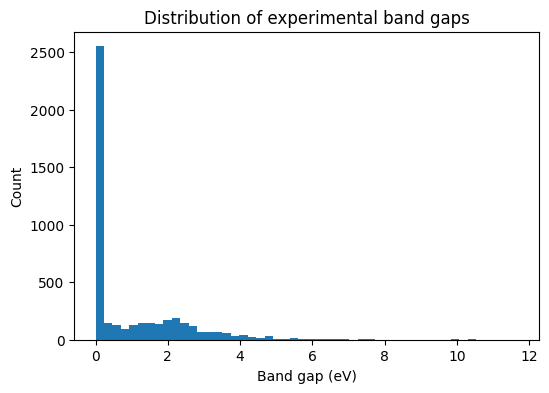

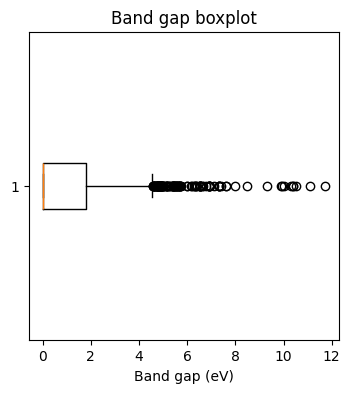

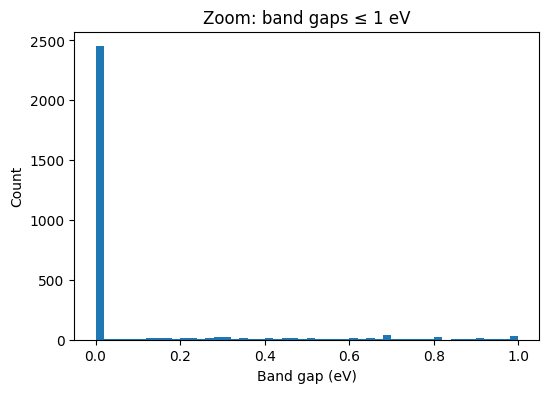

In [ ]:
y_series = pd.Series(y)

print(y_series.describe())

##fraction of materials with band gap near zero (metals?)
eps=0.1
frac_near_zero= np.mean(y <= eps)
print(f"Fraction of materials with band gap ≤ {eps} eV: {frac_near_zero:.3f}")

##visualise target distribution
plt.figure(figsize=(6,4))
plt.hist(y, bins=50)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.title("Distribution of experimental band gaps")
plt.show()

##boxplot
plt.figure(figsize=(4,4))
plt.boxplot(y, vert=False)
plt.xlabel("Band gap (eV)")
plt.title("Band gap boxplot")
plt.show()

##zoom in on low band gap region
plt.figure(figsize=(6,4))
plt.hist(y[y <= 1.0], bins=50)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.title("Zoom: band gaps ≤ 1 eV")
plt.show()

Since a large fraction of the dataset has band gap igual (or really close to) 0, these values dominate the distribution (~54%). To better visualise, we can also analyse the band gap excluding zero values.

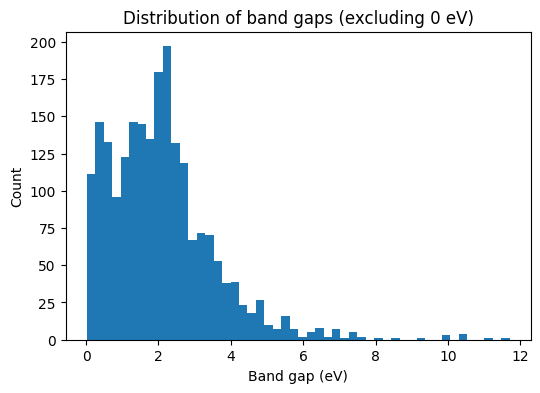

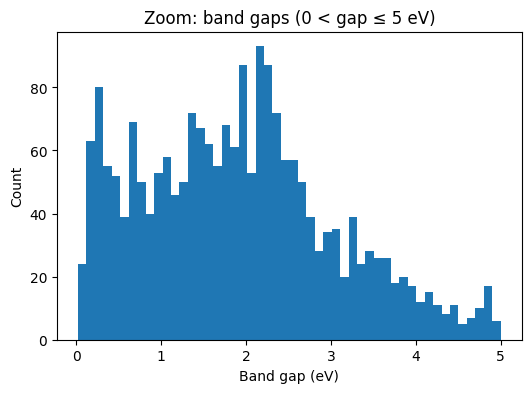

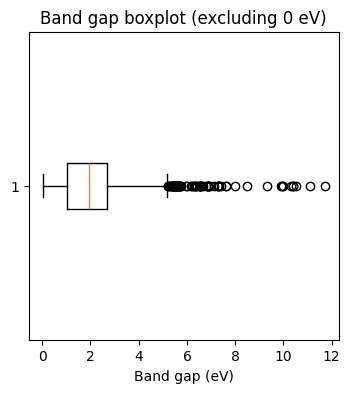

In [ ]:
y_no_zero=y[y > 0]

##histogram without zeros
plt.figure(figsize=(6,4))
plt.hist(y_no_zero, bins=50)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.title("Distribution of band gaps (excluding 0 eV)")
plt.show()

##zoom in on low band gap region without zeros
plt.figure(figsize=(6,4))
plt.hist(y_no_zero[y_no_zero <= 5.0], bins=50)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.title("Zoom: band gaps (0 < gap ≤ 5 eV)")
plt.show()

#boxplot without zeros
plt.figure(figsize=(4,4))
plt.boxplot(y[y > 0], vert=False)
plt.xlabel("Band gap (eV)")
plt.title("Band gap boxplot (excluding 0 eV)")
plt.show()

In [ ]:
constant_cols = X.columns[X.nunique() == 1] ##identify and remove constant columns that don't provide usefull info
print("Number of constant columns:", len(constant_cols))
X_clean = X.drop(columns=constant_cols)

print("X_clean shape:", X_clean.shape)


Number of constant columns: 0
X_clean shape: (4604, 132)


Some features have very different values, so we standardise them to be comparable, preventing the ones that had larger numerical ranges from dominating the analysis.

In [ ]:
scaler =StandardScaler() ##standardise features so they have mean=0 and std=1
X_scaled = scaler.fit_transform(X_clean)

print("X_scaled shape:", X_scaled.shape)

X_scaled shape: (4604, 132)


We can see that the band gap distribution is strongly zero-inflated, with more than half of the materials having gap values close to 0eV. Those zero values dominate the global distribuition and mask the behaviour of other regions, if excluded we can see more clearly. This also motivates a two-step model, since a single regression model could be dominated by these values.
After those steps, the dataset is clean and prepared with no missing values, no constant features and all variables standardised.

## **Part 3:** correlations

Objectives:
- reduce feature redundancy by removing highly correlated descriptors
- correlation matrix
- identify near-duplicate descriptors (|r|>0.95) --used this to be conservative

*Note*: many Magpie descriptors represent different statistical summaries (mean, max, mode, range, etc.) of the same underlying chemical property, they weren't removed with the r criteria, since they are intentionally redundant and have some importance for the DFT that will be applied later on.

The correlation matrix help us understand if there is redundancy among the Magpie descriptors, and also visualise it with a heatmap.

Correlation matrix shape: (132, 132)


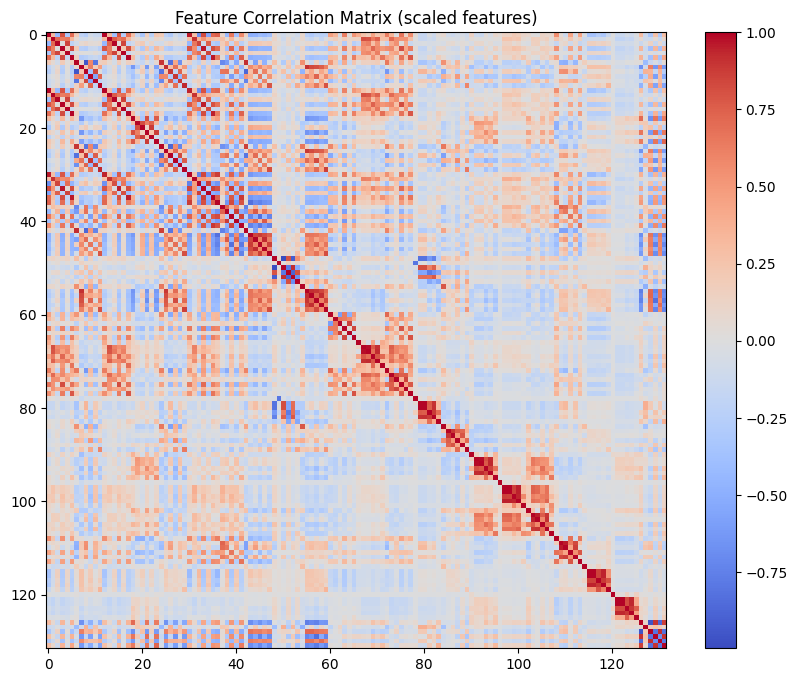

In [ ]:
corr_matrix = pd.DataFrame(X_scaled, columns=X_clean.columns).corr() ##correlation matrix for scaled features
print("Correlation matrix shape:", corr_matrix.shape)

plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Feature Correlation Matrix (scaled features)")
plt.show() ##heatmap of correlation matrix before feature correlation analysis

It's possible to identify highly correlated features with a threshold. We can, as an exploratory step, count how many features would be removed if we kept only one feature from each highly correlated pair.

In [ ]:
threshold = 0.95
high_corr_cols=[]
cols = list(corr_matrix.columns)

for i in range(len(cols)): #remove one of each pair of highly correlated features
    for j in range(i+1, len(cols)):
        r = corr_matrix.loc[cols[i], cols[j]]
        if abs(r) > threshold:
            high_corr_cols.append(cols[j])
high_corr_cols = list(set(high_corr_cols))
X_uncorr = X_clean.drop(columns=high_corr_cols)

print("Threshold |r| >", threshold)
print("Number of highly correlated columns (could be excluded):", len(high_corr_cols))
print("X_uncorr shape:", X_uncorr.shape)


Threshold |r| > 0.95
Number of highly correlated columns (could be excluded): 18
X_uncorr shape: (4604, 114)


X_uncorr_scaled shape: (4604, 114)
Updated correlation matrix shape: (114, 114)


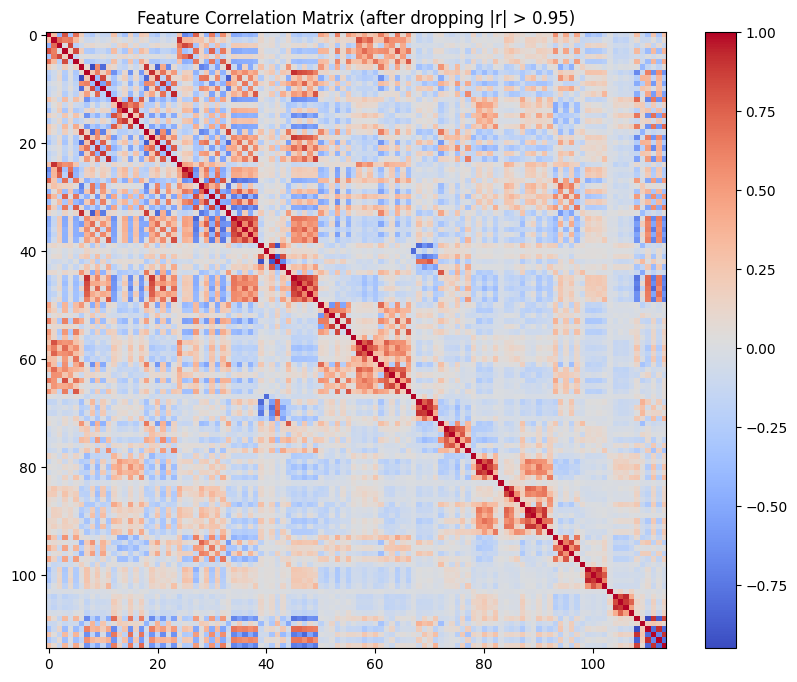

In [ ]:
###correlation matrix after removing highly correlated features (exploratory)
X_uncorr_scaled = scaler.fit_transform(X_uncorr)
corr_matrix_uncorr = pd.DataFrame(X_uncorr_scaled, columns=X_uncorr.columns).corr()

print("X_uncorr_scaled shape:", X_uncorr_scaled.shape)
print("Updated correlation matrix shape:", corr_matrix_uncorr.shape)

plt.figure(figsize=(10,8))
plt.imshow(corr_matrix_uncorr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Feature Correlation Matrix (after dropping |r| > 0.95)")
plt.show()

We look at the highest correlation between different features to see how much information is repeated across the features.

In [ ]:
#compare max off-diagonal correlation before and after correlation analysis
max_offdiag_before =np.max(np.abs(corr_matrix.values - np.eye(corr_matrix.shape[0])))
max_offdiag_after  = np.max(np.abs(corr_matrix_uncorr.values - np.eye(corr_matrix_uncorr.shape[0])))

print("Max |corr| off-diagonal BEFORE:", max_offdiag_before)
print("Max |corr| off-diagonal AFTER :", max_offdiag_after)

Max |corr| off-diagonal BEFORE: 0.9993251994036717
Max |corr| off-diagonal AFTER : 0.9496545525477645


We can create a table with those features that could be removed and their strongest correlation pairs to better visualize and understand our data.

In [ ]:
removed_summary =[]

for feat in high_corr_cols: ##for each removed feature, find the feature it was most correlated with
    best_abs = 0
    best_partner = None
    best_r = None
    for other in cols:
        if other != feat:
            r = corr_matrix.loc[feat, other]
            if abs(r) > best_abs:
                best_abs = abs(r)
                best_partner = other
                best_r = r
    removed_summary.append((feat, best_partner, best_r, best_abs))

removed_df = pd.DataFrame(
    removed_summary,
    columns=["removed_feature", "most_correlated_with", "corr", "abs_corr"]
).sort_values("abs_corr", ascending=False)

display(removed_df.head(30))

removed_feature            most_correlated_with      corr  \
3       MagpieData range NfUnfilled   MagpieData maximum NfUnfilled  0.999325   
11  MagpieData maximum AtomicWeight       MagpieData maximum Number  0.999292   
0         MagpieData range GSmagmom     MagpieData maximum GSmagmom  0.998917   
5      MagpieData mean AtomicWeight          MagpieData mean Number  0.998773   
4        MagpieData range GSbandgap    MagpieData maximum GSbandgap  0.998767   
10     MagpieData mode AtomicWeight          MagpieData mode Number  0.998651   
7   MagpieData minimum AtomicWeight       MagpieData minimum Number  0.997903   
6       MagpieData range NsUnfilled   MagpieData maximum NsUnfilled  0.996918   
1   MagpieData avg_dev AtomicWeight       MagpieData avg_dev Number  0.996462   
12       MagpieData range NsValence    MagpieData minimum NsValence -0.996191   
16    MagpieData range AtomicWeight         MagpieData range Number  0.995951   
17      MagpieData range NdUnfilled   MagpieData maximum NdUnfilled  0.991252   
14       MagpieData range NfValence    MagpieData maximum NfValence  0.979031   
8               MagpieData mean Row          MagpieData mean Number  0.963317   
9               MagpieData mode Row          MagpieData mode Number  0.961640   
15     MagpieData range GSvolume_pa  MagpieData maximum GSvolume_pa  0.957998   
13           MagpieData minimum Row       MagpieData minimum Number  0.954331   
2     MagpieData avg_dev NfUnfilled     MagpieData range NfUnfilled  0.951893   

    abs_corr  
3   0.999325  
11  0.999292  
0   0.998917  
5   0.998773  
4   0.998767  
10  0.998651  
7   0.997903  
6   0.996918  
1   0.996462  
12  0.996191  
16  0.995951  
17  0.991252  
14  0.979031  
8   0.963317  
9   0.961640  
15  0.957998  
13  0.954331  
2   0.951893

Also, after removing, it's intersting if we can see the strongest *remaining* correlations. This even highlight that Magpie descriptors remain redundant, and it's by design.

In [ ]:
pairs =[]
cols_uncorr = list(corr_matrix_uncorr.columns)
for i in range(len(cols_uncorr)): ##list all remaining feature pairs and their correlations
    for j in range(i+1, len(cols_uncorr)):
        r = corr_matrix_uncorr.loc[cols_uncorr[i], cols_uncorr[j]]
        pairs.append((cols_uncorr[i], cols_uncorr[j], r, abs(r)))

remaining_corr_df = pd.DataFrame(
    pairs, columns=["feature_1", "feature_2", "corr", "abs_corr"]
)
remaining_corr_df = remaining_corr_df.sort_values("abs_corr", ascending=False)
display(remaining_corr_df.head(10))

feature_1  \
6427  MagpieData minimum SpaceGroupNumber   
6116         MagpieData maximum NUnfilled   
664    MagpieData minimum MendeleevNumber   
6337         MagpieData maximum GSbandgap   
6397          MagpieData maximum GSmagmom   
1199      MagpieData mode MendeleevNumber   
3361   MagpieData range Electronegativity   
5847        MagpieData maximum NdUnfilled   
4095         MagpieData maximum NpValence   
6436    MagpieData range SpaceGroupNumber   

                                 feature_2      corr  abs_corr  
6427     MagpieData range SpaceGroupNumber -0.949655  0.949655  
6116            MagpieData range NUnfilled  0.948540  0.948540  
664       MagpieData range MendeleevNumber -0.943146  0.943146  
6337          MagpieData avg_dev GSbandgap  0.939996  0.939996  
6397           MagpieData avg_dev GSmagmom  0.935481  0.935481  
1199                MagpieData mode Column  0.931999  0.931999  
3361  MagpieData avg_dev Electronegativity  0.927010  0.927010  
5847         MagpieData avg_dev NdUnfilled  0.924436  0.924436  
4095            MagpieData range NpValence  0.921406  0.921406  
6436   MagpieData avg_dev SpaceGroupNumber  0.918448  0.918448

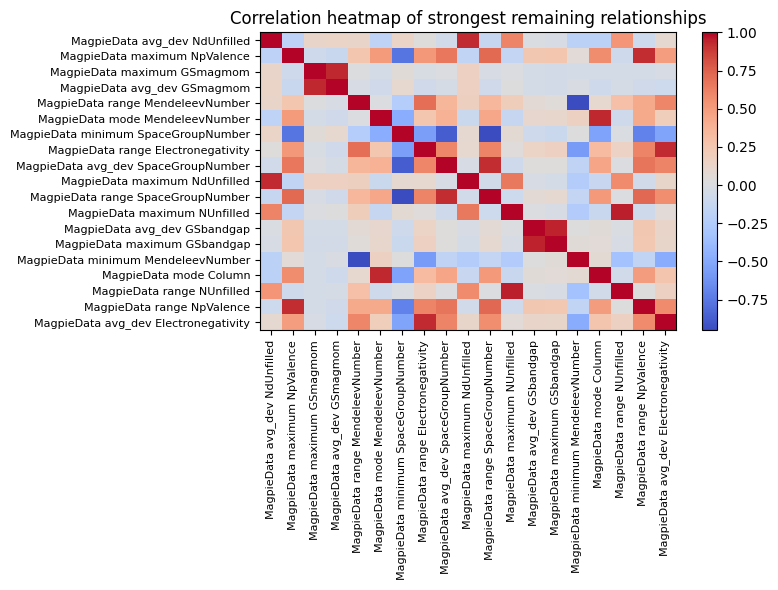

In [ ]:
##visualise strongest remaining correlations (10 in this case)
top_features_corr = list(set(
    remaining_corr_df.head(10)["feature_1"].tolist() +
    remaining_corr_df.head(10)["feature_2"].tolist()
))
sub_corr = corr_matrix_uncorr.loc[top_features_corr, top_features_corr]

plt.figure(figsize=(8,6))
plt.imshow(sub_corr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Correlation heatmap of strongest remaining relationships")
plt.xticks(range(len(top_features_corr)), top_features_corr, rotation=90, fontsize=8)
plt.yticks(range(len(top_features_corr)), top_features_corr, fontsize=8)
plt.tight_layout()
plt.show()

## **Part 4**: features

Objective:
- identify most relevant descriptors for predicting the band gap (in this case, 10)
- rank features by correlation with the target
- select top descriptors
- visualize feature importance
- inspect chemical trends

In [ ]:
#make sure to use X_clean and not X_uncorr for the following analysis
X_clean =X.copy()
scaler =StandardScaler()
X_scaled =scaler.fit_transform(X_clean)

print("X_clean shape:", X_clean.shape)
print("X_scaled shape:", X_scaled.shape)

X_clean shape: (4604, 132)
X_scaled shape: (4604, 132)


Calculate the correlation between each feature and the band gap, then ranking the features by the absolute value of their corelation with the band gap

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns)
corr_with_y =[]

for col in X_scaled_df.columns: ##for each remaining feature, compute correlation with the band gap
    r = np.corrcoef(X_scaled_df[col].values, y)[0, 1]
    corr_with_y.append(r)

##rank features by absolute correlation with target
feat_rank = pd.DataFrame({
    "feature": X_scaled_df.columns,
    "corr_with_y": corr_with_y,
    "abs_corr_with_y": np.abs(corr_with_y)
})

feat_rank = feat_rank.sort_values("abs_corr_with_y", ascending=False)

display(feat_rank.head(30))

feature  corr_with_y  abs_corr_with_y
57              MagpieData mean NpValence     0.458913         0.458913
129      MagpieData mean SpaceGroupNumber    -0.439529         0.439529
55           MagpieData maximum NpValence     0.422002         0.422002
131      MagpieData mode SpaceGroupNumber    -0.414991         0.414991
21               MagpieData mean MeltingT    -0.405884         0.405884
59              MagpieData mode NpValence     0.394536         0.394536
56             MagpieData range NpValence     0.389805         0.389805
126   MagpieData minimum SpaceGroupNumber    -0.387766         0.387766
7      MagpieData maximum MendeleevNumber     0.373902         0.373902
128     MagpieData range SpaceGroupNumber     0.362233         0.362233
23               MagpieData mode MeltingT    -0.359846         0.359846
43   MagpieData maximum Electronegativity     0.357248         0.357248
27                 MagpieData mean Column     0.350936         0.350936
45      MagpieData mean Electronegativity     0.350332         0.350332
44     MagpieData range Electronegativity     0.347157         0.347157
25              MagpieData maximum Column     0.345367         0.345367
18            MagpieData minimum MeltingT    -0.339740         0.339740
41         MagpieData mode CovalentRadius    -0.331874         0.331874
47      MagpieData mode Electronegativity     0.331436         0.331436
33                    MagpieData mean Row    -0.319726         0.319726
29                 MagpieData mode Column     0.315928         0.315928
39         MagpieData mean CovalentRadius    -0.315085         0.315085
35                    MagpieData mode Row    -0.311541         0.311541
46   MagpieData avg_dev Electronegativity     0.308767         0.308767
58           MagpieData avg_dev NpValence     0.307152         0.307152
110          MagpieData range GSvolume_pa     0.304551         0.304551
9         MagpieData mean MendeleevNumber     0.298287         0.298287
109        MagpieData maximum GSvolume_pa     0.295821         0.295821
36      MagpieData minimum CovalentRadius    -0.291409         0.291409
130   MagpieData avg_dev SpaceGroupNumber     0.290126         0.290126

In [ ]:
top_n=20 ##select top N features
top_features = feat_rank["feature"].head(top_n).tolist()
print("Top features selected:", len(top_features))
top_features_frame = feat_rank.head(top_n) ##dataframe of top features
display(top_features_frame)

X_top = X_scaled_df[top_features].values
print("X_top shape:", X_top.shape) ###final feature matrix with top N features

Top features selected: 20


feature  corr_with_y  abs_corr_with_y
57              MagpieData mean NpValence     0.458913         0.458913
129      MagpieData mean SpaceGroupNumber    -0.439529         0.439529
55           MagpieData maximum NpValence     0.422002         0.422002
131      MagpieData mode SpaceGroupNumber    -0.414991         0.414991
21               MagpieData mean MeltingT    -0.405884         0.405884
59              MagpieData mode NpValence     0.394536         0.394536
56             MagpieData range NpValence     0.389805         0.389805
126   MagpieData minimum SpaceGroupNumber    -0.387766         0.387766
7      MagpieData maximum MendeleevNumber     0.373902         0.373902
128     MagpieData range SpaceGroupNumber     0.362233         0.362233
23               MagpieData mode MeltingT    -0.359846         0.359846
43   MagpieData maximum Electronegativity     0.357248         0.357248
27                 MagpieData mean Column     0.350936         0.350936
45      MagpieData mean Electronegativity     0.350332         0.350332
44     MagpieData range Electronegativity     0.347157         0.347157
25              MagpieData maximum Column     0.345367         0.345367
18            MagpieData minimum MeltingT    -0.339740         0.339740
41         MagpieData mode CovalentRadius    -0.331874         0.331874
47      MagpieData mode Electronegativity     0.331436         0.331436
33                    MagpieData mean Row    -0.319726         0.319726

X_top shape: (4604, 20)


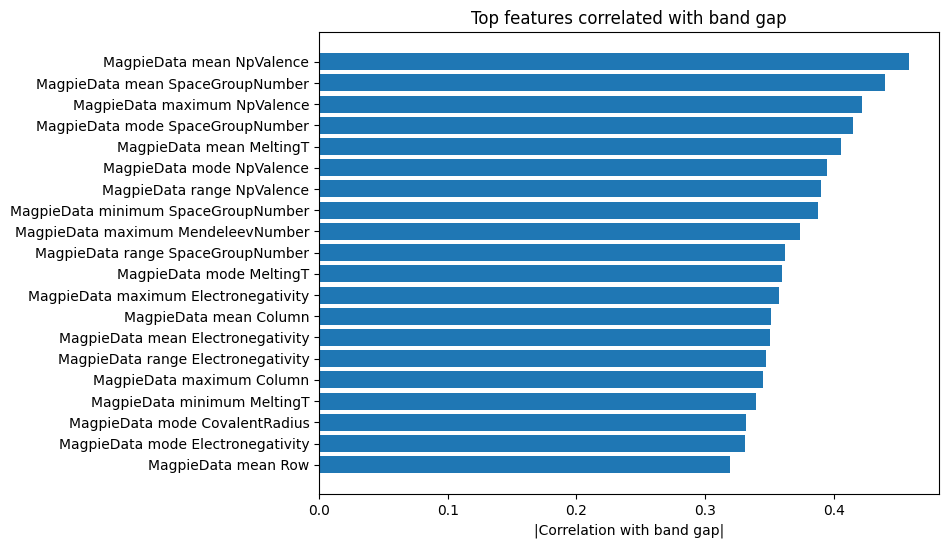

In [ ]:
#visualise top features correlation with band gap
plt.figure(figsize=(8,6))
plt.barh(top_features_frame["feature"], top_features_frame["abs_corr_with_y"])
plt.xlabel("|Correlation with band gap|")
plt.title("Top features correlated with band gap")
plt.gca().invert_yaxis()
plt.show()

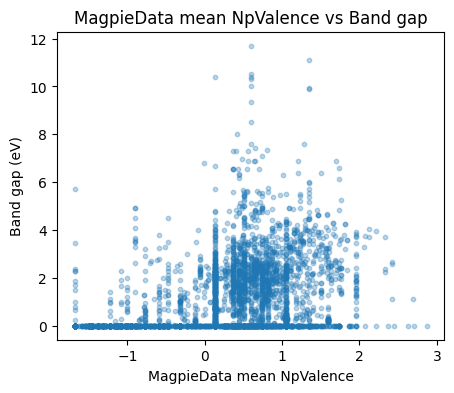

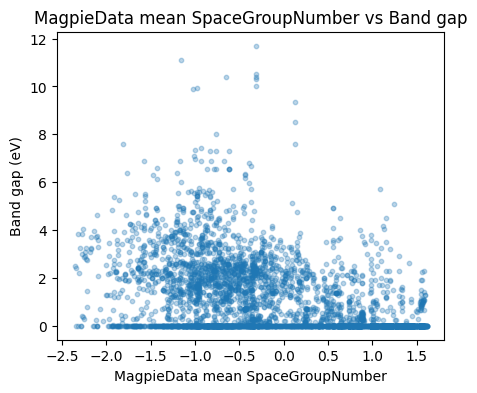

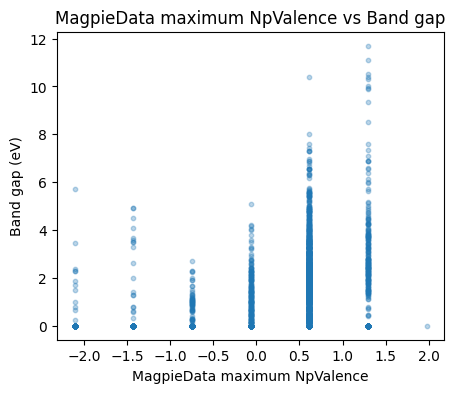

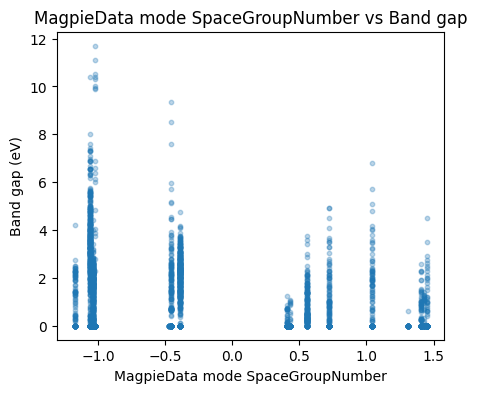

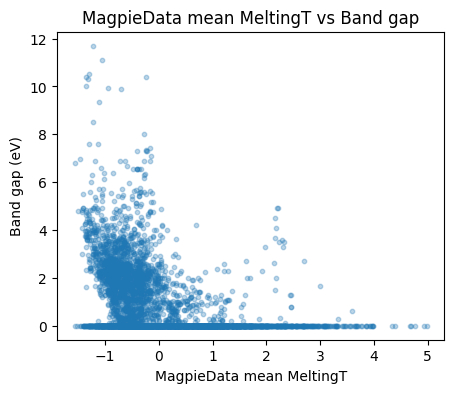

In [ ]:
##scatter plots of top 5 features vs band gap
for feat in top_features_frame["feature"][:5]:
    plt.figure(figsize=(5,4))
    plt.scatter(X_scaled_df[feat], y, alpha=0.3, s=10)
    plt.xlabel(feat)
    plt.ylabel("Band gap (eV)")
    plt.title(f"{feat} vs Band gap")
    plt.show()

One way of understanding the features is to train a Random Forest model to estimate which features are most important for predicting the band gap, and than rank those by importance.

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_clean, y) #train random forest model

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
importances = rf.feature_importances_ ##feature importances from random forest

rf_rank = pd.DataFrame()
rf_rank["feature"] = X_clean.columns
rf_rank["importance"] = importances
rf_rank = rf_rank.sort_values("importance", ascending=False) #ranking the features
top_n=30
rf_top = rf_rank.head(top_n)
display(rf_top)

feature  importance
57              MagpieData mean NpValence    0.223169
62             MagpieData range NdValence    0.041230
108        MagpieData minimum GSvolume_pa    0.035504
21               MagpieData mean MeltingT    0.034364
63              MagpieData mean NdValence    0.028953
46   MagpieData avg_dev Electronegativity    0.026510
75               MagpieData mean NValence    0.025587
10     MagpieData avg_dev MendeleevNumber    0.024460
44     MagpieData range Electronegativity    0.024353
33                    MagpieData mean Row    0.023968
28              MagpieData avg_dev Column    0.019682
111           MagpieData mean GSvolume_pa    0.019335
45      MagpieData mean Electronegativity    0.016886
105             MagpieData mean NUnfilled    0.016478
22            MagpieData avg_dev MeltingT    0.015402
39         MagpieData mean CovalentRadius    0.015273
112        MagpieData avg_dev GSvolume_pa    0.014514
3                  MagpieData mean Number    0.014053
87             MagpieData mean NpUnfilled    0.012989
58           MagpieData avg_dev NpValence    0.012600
116            MagpieData range GSbandgap    0.012377
1               MagpieData maximum Number    0.011872
13        MagpieData maximum AtomicWeight    0.011799
130   MagpieData avg_dev SpaceGroupNumber    0.011523
76            MagpieData avg_dev NValence    0.011251
15           MagpieData mean AtomicWeight    0.010807
110          MagpieData range GSvolume_pa    0.010535
129      MagpieData mean SpaceGroupNumber    0.010456
117             MagpieData mean GSbandgap    0.009818
106          MagpieData avg_dev NUnfilled    0.009727

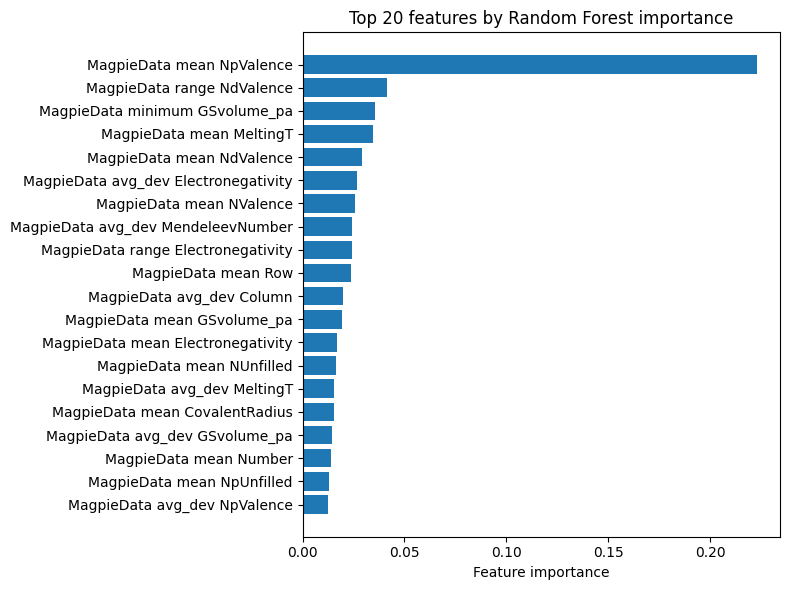

In [ ]:
top_plot=20
rf_top_plot = rf_rank.head(top_plot)

#bar plot -> feature importance from random forest
plt.figure(figsize=(8,6))
plt.barh(rf_top_plot["feature"], rf_top_plot["importance"])
plt.xlabel("Feature importance")
plt.title("Top 20 features by Random Forest importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

It's possible to compare the correlation-based ranking with the random forest importance.

In [ ]:
N=15
top_corr_list = feat_rank["feature"].head(N).tolist()
top_rf_list = rf_rank["feature"].head(N).tolist()
overlap =[]
only_corr =[]
only_rf =[]
for f in top_corr_list: ##checkl for features only in correlation
    if f in top_rf_list:
        overlap.append(f)
    else:
        only_corr.append(f)
for f in top_rf_list: #check for features only in raindom forest
    if f not in top_corr_list:
        only_rf.append(f)
max_len = max(len(overlap), len(only_corr), len(only_rf))

summary_df = pd.DataFrame({
    "in_both": overlap + [None]*(max_len - len(overlap)),
    "only_corr": only_corr + [None]*(max_len - len(only_corr)),
    "only_rf": only_rf + [None]*(max_len - len(only_rf))
})

display(summary_df.style.hide(axis="index"))

Only Random Forest (top 5): ['MagpieData range NdValence', 'MagpieData minimum GSvolume_pa', 'MagpieData mean NdValence', 'MagpieData avg_dev Electronegativity', 'MagpieData mean NValence']


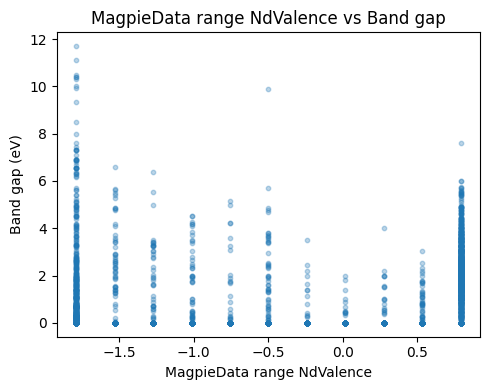

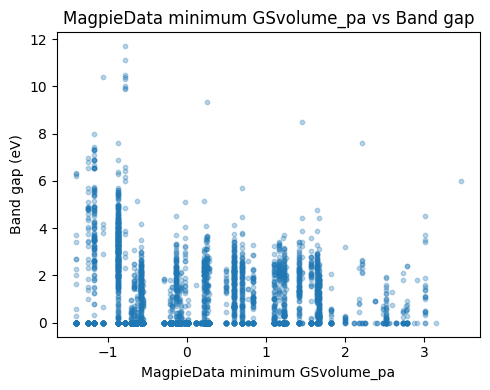

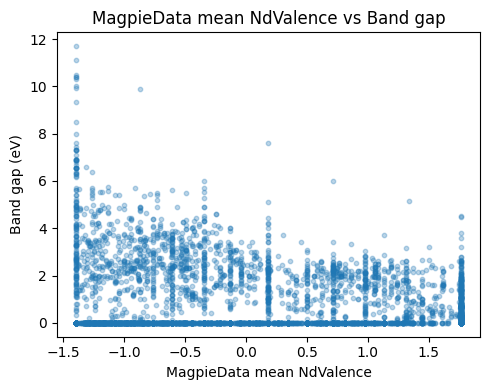

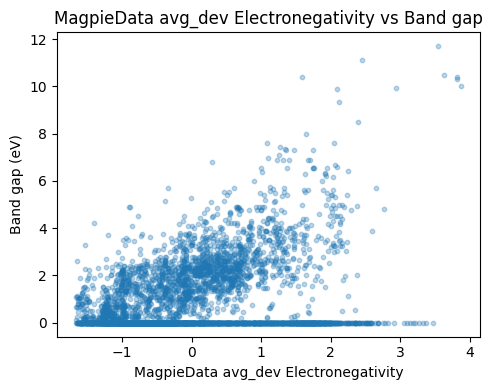

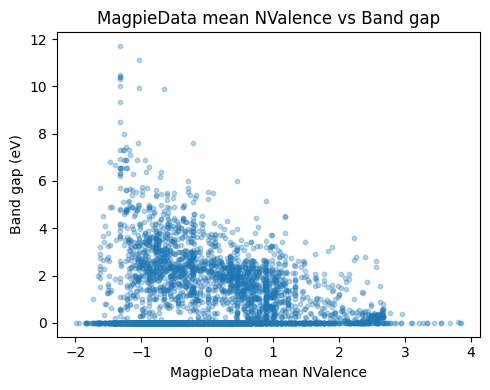

In [ ]:
scatter_rf = only_rf[:5]
print("Only Random Forest (top 5):", scatter_rf)

for feat in scatter_rf:
    plt.figure(figsize=(5,4))
    plt.scatter(X_scaled_df[feat], y, alpha=0.3, s=10)
    plt.xlabel(feat)
    plt.ylabel("Band gap (eV)")
    plt.title(f"{feat} vs Band gap")
    plt.tight_layout()
    plt.show()

Both analysis methods (correlation and random forest) partially agree on key features, such as those related to electronegativity and atomic radius. However, random forest highlights additional features that may capture non-linear relationships with the band gap.

## **Part 5**: PCA

Objective:
- reduce dimensionality and visualize the structure of the data
- apply PCA
- analyse explained variance
- select the number of components
- visualize PCs

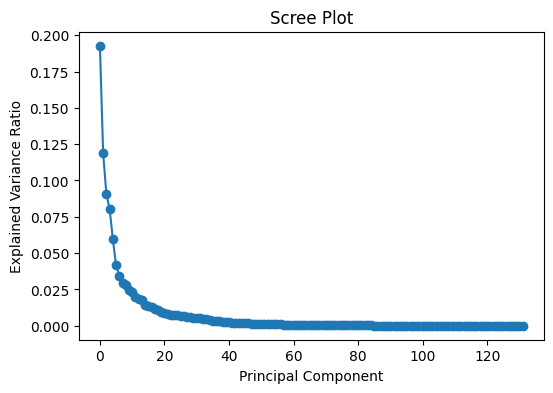

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

##scree plot
plt.figure(figsize=(6,4))
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()

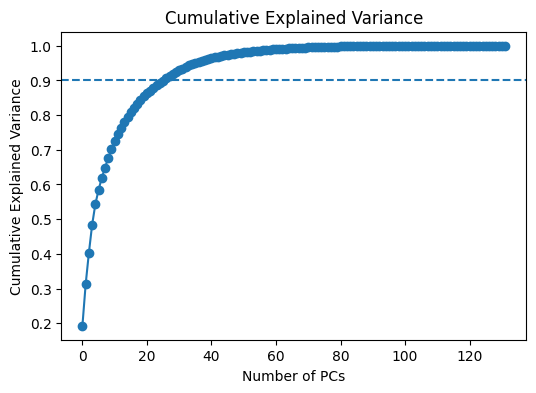

In [ ]:
##accumulated explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

#plot cumulative explained variance
plt.figure(figsize=(6,4))
plt.plot(cum_var, marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.axhline(0.9, linestyle="--")
plt.show()

In [ ]:
n_90 = np.argmax(cum_var >= 0.9) + 1 ##number of PCs to reach 90% variance (this is to reduce PCA)
print("Number of PCs for 90% variance:", n_90)

pca_red = PCA(n_components=n_90) ##PCA with reduced number of components
X_pca_red = pca_red.fit_transform(X_scaled)
print("X_pca_red shape:", X_pca_red.shape)

Number of PCs for 90% variance: 27
X_pca_red shape: (4604, 27)


In [ ]:
pc_variance = pd.DataFrame()
pc_variance["PC"] = ["PC" + str(i+1) for i in range(len(pca_red.explained_variance_ratio_))]
pc_variance["explained_variance"] = pca_red.explained_variance_ratio_
pc_variance["cumulative_variance"] = np.cumsum(pca_red.explained_variance_ratio_)

display(pc_variance)

PC  explained_variance  cumulative_variance
0    PC1            0.192795             0.192795
1    PC2            0.118887             0.311682
2    PC3            0.090746             0.402428
3    PC4            0.080545             0.482974
4    PC5            0.059707             0.542681
5    PC6            0.041594             0.584274
6    PC7            0.034575             0.618849
7    PC8            0.029496             0.648345
8    PC9            0.028196             0.676541
9   PC10            0.024819             0.701361
10  PC11            0.023539             0.724900
11  PC12            0.020073             0.744974
12  PC13            0.018258             0.763232
13  PC14            0.017437             0.780669
14  PC15            0.014440             0.795108
15  PC16            0.013840             0.808948
16  PC17            0.012638             0.821587
17  PC18            0.011732             0.833319
18  PC19            0.010843             0.844162
19  PC20            0.009641             0.853804
20  PC21            0.008786             0.862590
21  PC22            0.007871             0.870460
22  PC23            0.007677             0.878137
23  PC24            0.007436             0.885573
24  PC25            0.007125             0.892698
25  PC26            0.006829             0.899527
26  PC27            0.006662             0.906189

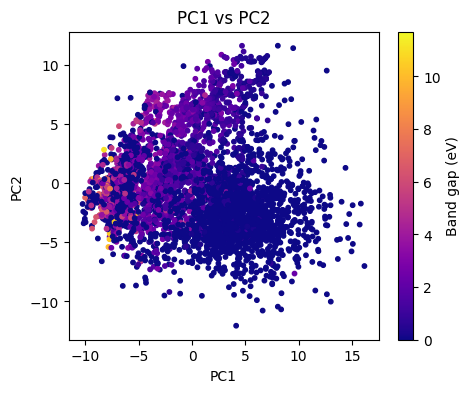

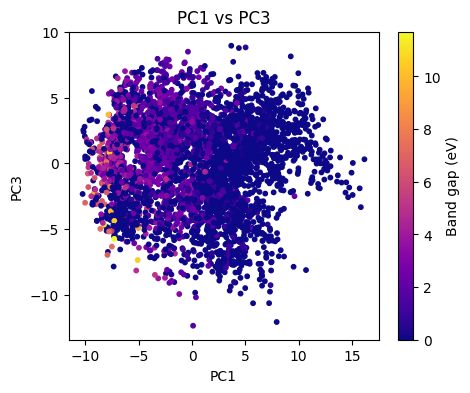

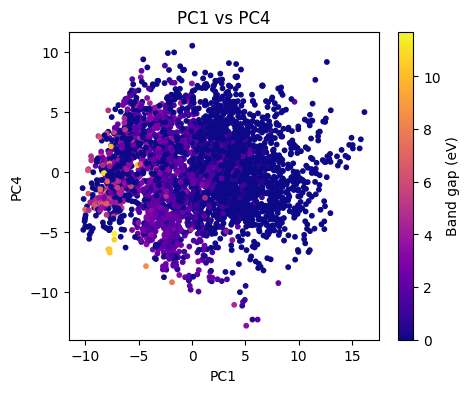

In [ ]:
pairs = [(0,1), (0,2), (0,3)] ##can change pairs to visualise other PC combinations

for i, j in pairs: #scatter plots of selected PC pairs colored by band gap
    plt.figure(figsize=(5,4))
    plt.scatter(X_pca_red[:,i], X_pca_red[:,j], c=y, cmap="plasma", s=10)
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PC{i+1} vs PC{j+1}")
    plt.colorbar(label="Band gap (eV)")
    plt.show()

The loadings tell us which original features contribute most to each principal component.

In [ ]:
loadings = pd.DataFrame(pca_red.components_.T)
loadings.index = X_clean.columns
loadings.columns = ["PC" + str(i+1) for i in range(pca_red.n_components_)]
 ##loadings are the weights of each original feature in the PCs

for pc in loadings.columns: ##display top 3 features contributing to each PC
    top3 = loadings[pc].abs().sort_values(ascending=False).head(3).index
    pc_table = pd.DataFrame({
        "feature": top3,
        "loading": [loadings.loc[f, pc] for f in top3],
        "abs_loading": [abs(loadings.loc[f, pc]) for f in top3]
    })

    display(pc_table.style.hide(axis="index").format({"loading": "{:.3f}", "abs_loading": "{:.3f}"}))

In [ ]:
rows =[]
for pc in loadings.columns:
    top3 = loadings[pc].abs().sort_values(ascending=False).head(3).index
    for feat in top3:
        rows.append({
            "PC": pc,
            "feature": feat,
            "loading": loadings.loc[feat, pc],
            "abs_loading": abs(loadings.loc[feat, pc])
        })

loadings_summary = pd.DataFrame(rows)
display(loadings_summary.style.hide(axis="index").format({"loading": "{:.3f}", "abs_loading": "{:.3f}"}))


## **Part6**: k-means clustering

Objectives:

- identify natural groupings of materials based on their chemical descriptors
- test multiple clusters
- use the elbow method and silhouette score
- train the final k-means model
- assign labels

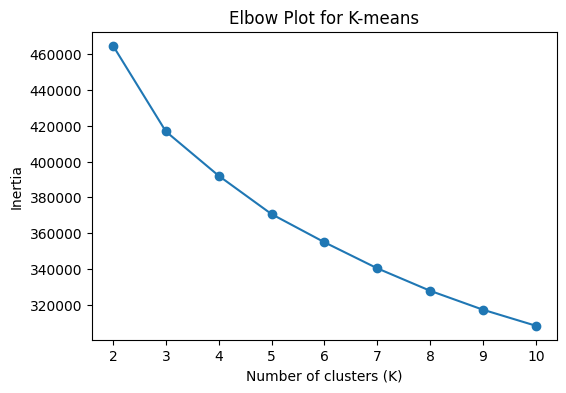

In [ ]:
inertias =[]
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_red)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Plot for K-means")
plt.show()

NOTE: the elbow is not well defined, we can see a clear reduction around K = 3-5.
With k=3 we could separate metals/semiconductors/insulating
with k=5 we could separate oxide/sulfide/halides

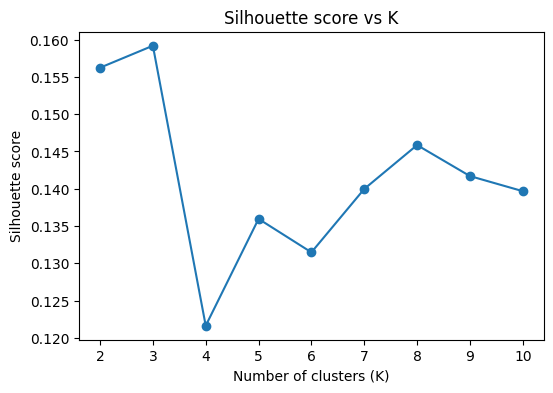

In [ ]:
K_range = range(2, 11)
sil_scores =[]
for k in K_range: #compute silhouette scores for different K
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca_red)
    sil = silhouette_score(X_pca_red, labels)
    sil_scores.append(sil)

#plot silhouette scores vs K
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs K")
plt.show()
sil_table = pd.DataFrame({"K": list(K_range), "silhouette": sil_scores})
display(sil_table.style.hide(axis="index").format({"silhouette": "{:.3f}"}))

The silhouette score can evalueta the separation between clusters, this results support the elbow plot.

Clusters (K=3) shape: (4604,)


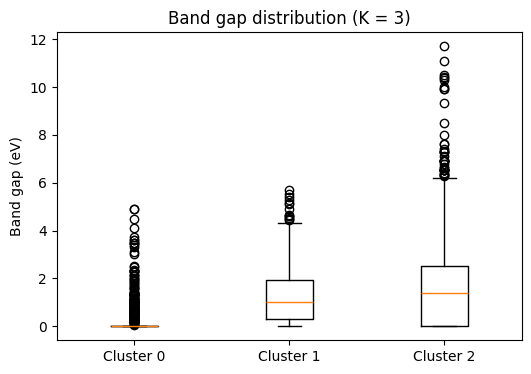

In [ ]:
###K-means clustering with K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_3 = kmeans_3.fit_predict(X_pca_red)
print("Clusters (K=3) shape:", clusters_3.shape)

#boxplot
df["cluster_3"] = clusters_3
plt.figure(figsize=(6,4))
plt.boxplot(
    [df[df["cluster_3"] == i]["gap expt"] for i in range(3)],
    labels=[f"Cluster {i}" for i in range(3)]
)
plt.ylabel("Band gap (eV)")
plt.title("Band gap distribution (K = 3)")
plt.show()

Clusters (K=5) shape: (4604,)


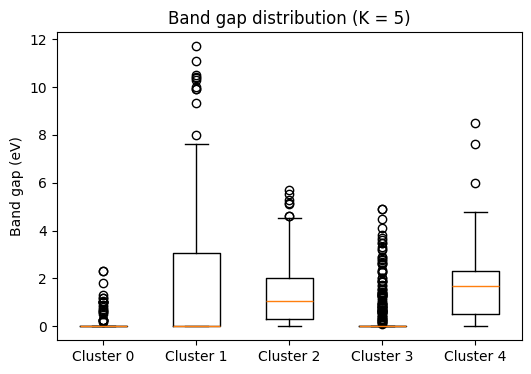

In [ ]:
###k-means with K=5
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_5 = kmeans_5.fit_predict(X_pca_red)
print("Clusters (K=5) shape:", clusters_5.shape)

#boxplot
df["cluster_5"] = clusters_5
plt.figure(figsize=(6,4))
plt.boxplot(
    [df[df["cluster_5"] == i]["gap expt"] for i in range(5)],
    labels=[f"Cluster {i}" for i in range(5)]
)
plt.ylabel("Band gap (eV)")
plt.title("Band gap distribution (K = 5)")
plt.show()

In [ ]:
rows =[]
eps=0.1

#for k=3
sil_3 = silhouette_score(X_pca_red, clusters_3)
inertia_3 = kmeans_3.inertia_
for c in sorted(np.unique(clusters_3)):
    gaps = df[df["cluster_3"] == c]["gap expt"]
    row = {
        "K": 3,
        "cluster": c,
        "size": len(gaps),
        "mean_gap": gaps.mean(),
        "median_gap": gaps.median(),
        "std_gap": gaps.std(),
        "min_gap": gaps.min(),
        "max_gap": gaps.max(),
        "frac_gap_less_0.1": (gaps <= eps).mean(),
        "inertia": inertia_3,
        "silhouette": sil_3
    }
    rows.append(row)

#for k=5
sil_5 = silhouette_score(X_pca_red, clusters_5)
inertia_5 = kmeans_5.inertia_
for c in sorted(np.unique(clusters_5)):
    gaps = df[df["cluster_5"] == c]["gap expt"]
    row = {
        "K": 5,
        "cluster": c,
        "size": len(gaps),
        "mean_gap": gaps.mean(),
        "median_gap": gaps.median(),
        "std_gap": gaps.std(),
        "min_gap": gaps.min(),
        "max_gap": gaps.max(),
        "frac_gap_less_0.1": (gaps <= eps).mean(),
        "inertia": inertia_5,
        "silhouette": sil_5
    }
    rows.append(row)


comparison_table = pd.DataFrame(rows)
display(comparison_table.style.hide(axis="index"))

it seems like k=3 defines better clusters (higher silhouette score)

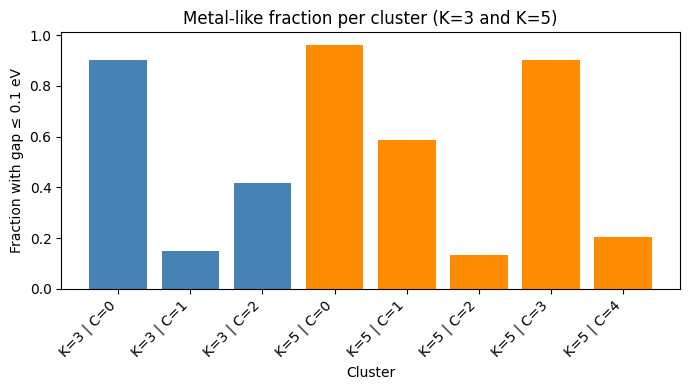

In [ ]:
tbl = comparison_table.copy()
tbl["cluster_id"] = "K=" + tbl["K"].astype(str) + " | C=" + tbl["cluster"].astype(str)

#visualise fraction of metals (gap ≤ 0.1 eV) per cluster
colors = ["steelblue" if k == 3 else "darkorange" for k in tbl["K"]]
plt.figure(figsize=(7,4))
plt.bar(tbl["cluster_id"], tbl["frac_gap_less_0.1"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Fraction with gap ≤ 0.1 eV")
plt.title("Metal-like fraction per cluster (K=3 and K=5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

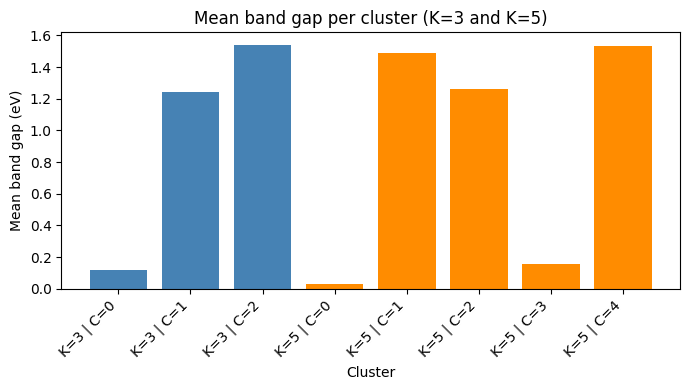

In [ ]:
tbl = comparison_table.copy()
tbl["cluster_id"] = "K=" + tbl["K"].astype(str) + " | C=" + tbl["cluster"].astype(str)

#visualise mean band gap per cluster
colors = ["steelblue" if k == 3 else "darkorange" for k in tbl["K"]]
plt.figure(figsize=(7,4))
plt.bar(tbl["cluster_id"], tbl["mean_gap"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Mean band gap (eV)")
plt.title("Mean band gap per cluster (K=3 and K=5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
##try to find representative compositions from each cluster (K=3)
#5 low-gap and 5 high-gap examples per cluster
examples =[]
for c in sorted(df["cluster_3"].unique()):
    sub = df[df["cluster_3"] == c][["formula", "gap expt"]].sort_values("gap expt")
    low = sub.head(5)
    high = sub.tail(5)
    low["type"] = "low_gap"
    high["type"] = "high_gap"
    low["cluster"] = c
    high["cluster"] = c
    examples.append(low)
    examples.append(high)
cluster_examples = pd.concat(examples).reset_index(drop=True)

display(cluster_examples)

formula  gap expt      type  cluster
0      Sc3Fe2Si3      0.00   low_gap        0
1         ScBIr3      0.00   low_gap        0
2        ScAlNi2      0.00   low_gap        0
3           ScAg      0.00   low_gap        0
4         Sc8Te3      0.00   low_gap        0
5           SrTe      3.73  high_gap        0
6           LaB6      4.10  high_gap        0
7          Rb2Te      4.50  high_gap        0
8           PrB6      4.90  high_gap        0
9           NdB6      4.90  high_gap        0
10         Ge3Sb      0.00   low_gap        1
11         Ge2Os      0.00   low_gap        1
12         GeAs3      0.00   low_gap        1
13   Ge5(Te4As)2      0.00   low_gap        1
14      Hg2Sb2O7      0.00   low_gap        1
15          FeI2      5.15  high_gap        1
16     Ge(SeO3)2      5.27  high_gap        1
17    In2B(PO4)3      5.39  high_gap        1
18          GeO2      5.54  high_gap        1
19         CdCl2      5.70  high_gap        1
20        Fe4O7F      0.00   low_gap        2
21        EuRhO3      0.00   low_gap        2
22        EuSbO3      0.00   low_gap        2
23  Fe4Si2Sn7O16      0.00   low_gap        2
24       Fe6O7F5      0.00   low_gap        2
25           BeO     10.39  high_gap        2
26           RbF     10.40  high_gap        2
27           NaF     10.50  high_gap        2
28          MgF2     11.10  high_gap        2
29           LiF     11.70  high_gap        2

The k=means clustering can show that we have distinct chemically meaningful groups, especially related to near zero band gap. We can interpret those as metals, semi-conductors and inslating. These results also support the two-step modelling strategy.

## **Part 7:** visualization

Objectives:
- interpret the clusters and PCA
- visualize clusters in PCA
- compare band gaps per cluster
- relate findings to materials (metal/non-metal)

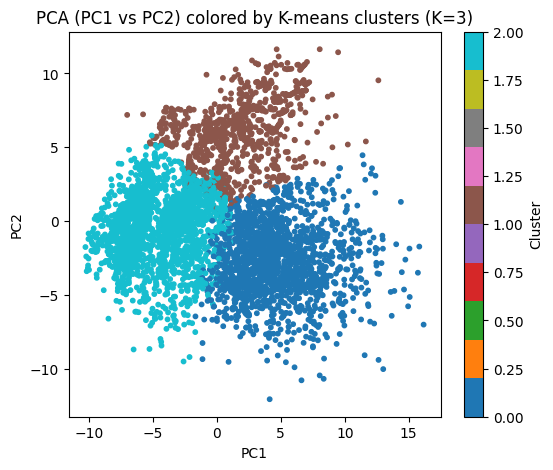

In [ ]:
#visualise K=3 clusters in PCA space, to see how the unsupervised groups separate in the reduced dimensions
plt.figure(figsize=(6,5))
plt.scatter(X_pca_red[:,0], X_pca_red[:,1], c=clusters_3, cmap="tab10", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) colored by K-means clusters (K=3)") #can change PC pairs
plt.colorbar(label="Cluster")
plt.show()

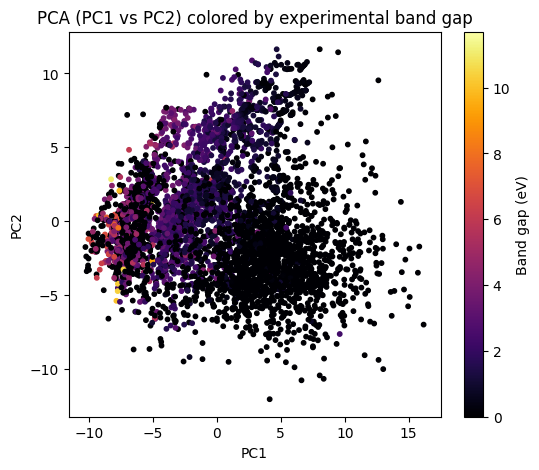

In [ ]:
#visualise band gap in PCA space to see how the band gap varies across the reduced dimensions
plt.figure(figsize=(6,5))
plt.scatter(X_pca_red[:,0], X_pca_red[:,1], c=y, cmap="inferno", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) colored by experimental band gap")
plt.colorbar(label="Band gap (eV)")
plt.show()

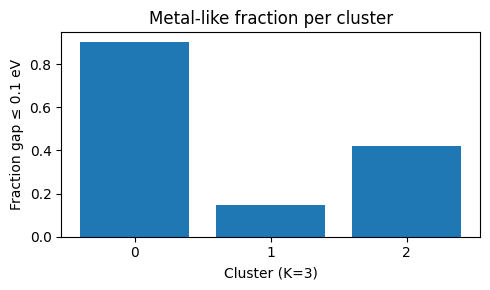

In [ ]:
eps = 0.1
metal_frac = df.groupby("cluster_3")["gap expt"].apply(lambda s: (s <= eps).mean())

##visualise fraction of metals (gap ≤ 0.1 eV) per cluster
plt.figure(figsize=(5,3))
plt.bar(metal_frac.index.astype(str), metal_frac.values)
plt.xlabel("Cluster (K=3)")
plt.ylabel("Fraction gap ≤ 0.1 eV")
plt.title("Metal-like fraction per cluster")
plt.tight_layout()
plt.show()

simple chemical family labels were assigned from composition to each cluster to support interpretation.

In [ ]:
def get_family(formula):
    comp = Composition(formula)
    elems = {el.symbol for el in comp.elements}
    hits =[]
    anion_groups = {
    "oxide": {"O"},
    "halide": {"F", "Cl", "Br", "I"},
    "chalcogenide": {"S", "Se", "Te"},
    "nitride/phosphide": {"N", "P", "As", "Sb", "Bi"},
    "carbide/boride": {"C", "B"},
    "hydride": {"H"}
    }
    for name, group in anion_groups.items():
        if len(elems.intersection(group)) > 0:
            hits.append(name)

    if len(hits) == 0:
        return "other"
    if len(hits) == 1:
        return hits[0]
    return "mixed"
df["family"] = df["formula"].apply(get_family)

In [ ]:
family_counts = pd.crosstab(df["cluster_3"], df["family"])
family_frac = pd.crosstab(df["cluster_3"], df["family"], normalize="index")

display(family_counts)
display(family_frac.style.format("{:.2f}"))

family     carbide/boride  chalcogenide  halide  hydride  mixed  \
cluster_3                                                         
0                     151            98      10        2     15   
1                       5           367      23        0    320   
2                      36           558      93       13    755   

family     nitride/phosphide  other  oxide  
cluster_3                                   
0                        217   1131     10  
1                        144     47      9  
2                         82      6    512

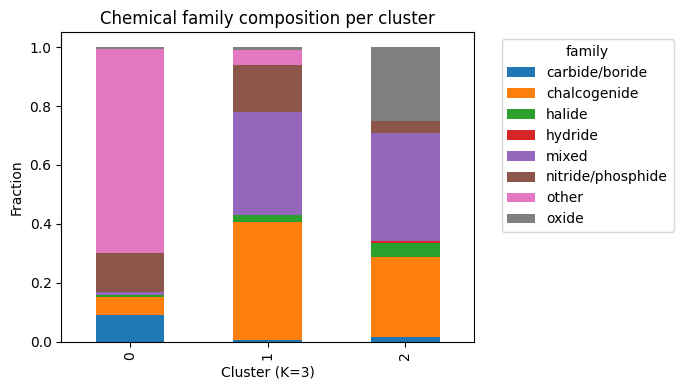

In [ ]:
family_frac = pd.crosstab(df["cluster_3"], df["family"], normalize="index")
family_frac.plot(kind="bar", stacked=True, figsize=(7,4))
plt.xlabel("Cluster (K=3)")
plt.ylabel("Fraction")
plt.title("Chemical family composition per cluster")
plt.legend(title="family", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# **3. Benchmarking across the basic frameworks (Will & Will)**
*Training and assessment of various baseline models, hyperparameter tuning and plotting peformance*

In [ ]:
df = pd.read_csv("expt_bandgap_dataset.csv")
df = df.drop(['formula'],axis=1)
X = df.drop(['gap expt'],axis=1).values
y = df['gap expt'].values

NameError: name 'pd' is not defined

In [ ]:
tree_model = DecisionTreeRegressor(random_state=42)

mae_scores = -cross_val_score(tree_model, X, y, cv=5, scoring="neg_mean_absolute_error")
rmse_scores = np.sqrt(-cross_val_score(tree_model, X, y, cv=5, scoring="neg_mean_squared_error"))

print(f"Mean absolute error: {mae_scores.mean():.2f} (+/- {mae_scores.std() * 2:.2f})")
print(f"Root mean squared error: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})")

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

mae_scores = -cross_val_score(rf_model, X, y, cv=5, scoring="neg_mean_absolute_error")
rmse_scores = np.sqrt(-cross_val_score(rf_model, X, y, cv=5, scoring="neg_mean_squared_error"))

print(f"Mean absolute error: {mae_scores.mean():.2f} (+/- {mae_scores.std() * 2:.2f})")
print(f"Root mean squared error: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})")

In [ ]:
xgb_model = XGBRegressor(random_state=42)

scores = cross_val_score(xgb_model, X, y, cv=5, scoring="neg_mean_absolute_error")
mae_scores = -scores
mae_scores
print(f"Mean absolute error: {mae_scores.mean():.2f} (+/- {mae_scores.std() * 2:.2f})")

In [ ]:
# tune hyperparameters for best baseline model - xgbregressor

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 8, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_model, param_dist, n_iter=10, cv=5, random_state=42
)

random_search.fit(X, y)

print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best mean absolute error: {-random_search.best_score_:.2f}")

In [ ]:
xgb_model = XGBRegressor(n_estimators=200,subsample=0.8,max_depth=7,learning_rate=0.1,random_state=42)

scores = cross_val_score(xgb_model, X, y, cv=5, scoring="neg_mean_absolute_error")
mae_scores = -scores
mae_scores
print(f"Mean absolute error: {mae_scores.mean():.2f} (+/- {mae_scores.std() * 2:.2f})")

In [ ]:
# actual by predicted plot for tuned xgbregressor

from sklearn.model_selection import cross_val_predict

# predictions using CV
y_pred = cross_val_predict(xgb_model, X, y, cv=5)

# actual by predicted plot
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted (CV)')
plt.title('Actual by predicted')

In [ ]:
plt.hist((y-y_pred), bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

Implementation of two-step model using XGBClassifier and regressor as examples, any combination of classifier and regressor can be used

In [ ]:
class TwoStepModel:
    """"class to combine classifier and regressor models into one model"""

    def __init__(self,classifier,regressor):
        self.classifier = classifier
        self.regressor = regressor

    def get_params(self, deep=True):
      """allows sklearn cross validation to call model parameters"""
        return {
            'classifier': self.classifier,
            'regressor': self.regressor}

    def fit(self, X_train, y_train):
        """pass in X_train and y_train as pandas dataframes and fit models"""
        y_binary = (y_train > 0).astype(int)
        self.classifier.fit(X_train, y_binary)

        # mask to filter all y values that are non zero
        mask = y_train > 0
        self.regressor.fit(X_train[mask],y_train[mask])

        return self

    def predict(self,X_test):
        """pass in X_test to get y_pred"""
        # give array populated by '0' and '1':
        binary_predictions  = self.classifier.predict(X_test)

        # create correct shape array populated by zeros:
        y_pred = np.zeros(len(X_test))

        # which predictions are '1'?
        mask = binary_predictions == 1

        # use mask to fill in relevent values from regressor preds into final y_pred

        regressor_pred = self.regressor.predict(X_test)
        y_pred[mask] = regressor_pred[mask]

        return(y_pred)

In [ ]:
# using the two-step model class with cross validation (also works with train/test split) - insert desired models and parameters as appropriate

model = TwoStepModel(XGBClassifier(subsample=0.8, n_estimators=300, max_depth=7, learning_rate=0.3, random_state=42),
                     XGBRegressor(subsample=0.8, n_estimators=200, max_depth=7, learning_rate=0.1,random_state=42)
                    )

scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
mae_scores = -scores
print(f"Mean absolute error: {mae_scores.mean():.2f} (+/- {mae_scores.std() * 2:.2f})")

# **4. Two Step Physical Models (Shuo)**



Based on that baseline, we develop a universal structure to easily try out as many different models as possible in a same pipeline. In this structure, we can explore more ideas.

## **Part 1**: Optional Feature Selection
Let's start from  selecting some important features sorted by feature importance.

In [ ]:
IMPORTANT_FEATURES = [
    'MagpieData maximum MendeleevNumber', 'MagpieData mean AtomicWeight',
    'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT',
    'MagpieData mean MeltingT', 'MagpieData minimum Column',
    'MagpieData range Column', 'MagpieData avg_dev Column',
    'MagpieData mode Column', 'MagpieData range Row', 'MagpieData mean Row',
    'MagpieData range Electronegativity', 'MagpieData avg_dev Electronegativity',
    'MagpieData mode Electronegativity', 'MagpieData mean NpValence',
    'MagpieData maximum NdValence', 'MagpieData range NdValence',
    'MagpieData mean NdValence', 'MagpieData maximum NfValence',
    'MagpieData mean NfValence', 'MagpieData mean NValence',
    'MagpieData mode NValence', 'MagpieData maximum NpUnfilled',
    'MagpieData range NpUnfilled', 'MagpieData mean NpUnfilled',
    'MagpieData range NUnfilled', 'MagpieData mean NUnfilled',
    'MagpieData mode NUnfilled', 'MagpieData minimum GSvolume_pa',
    'MagpieData mode GSvolume_pa', 'MagpieData maximum GSbandgap',
    'MagpieData range GSbandgap', 'MagpieData mode GSbandgap',
    'MagpieData mean GSmagmom', 'MagpieData mode SpaceGroupNumber'
]

## **Part 2**: Model Warehouse
Then we can build a warehouse to store different models. Some are pre-built deep learning models like CNN with fixed structure, while others could be flexible machine learning models with changable hyper parameters. We listed the sggested range of those hyper parameters based on experience for hyper parameter optimization.

In [ ]:
PARAM_GRIDS = {
    'XGBoost': {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [3, 5, 6, 8, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.5, 1]
    },
    'CatBoost': {
        'iterations': [500, 1000, 1500],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count': [32, 64, 128]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'epsilon': [0.01, 0.1, 0.5]
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2']
    },
    'LDA': {
        'solver': ['svd', 'lsqr', 'eigen']
    },
    'MLP': {
        'hidden_layer_sizes': [(128, 64), (256, 128, 64), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'batch_size': [32, 64, 128]
    },
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
    },
    'KRR': {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'gamma': [0.001, 0.01, 0.1, 1.0],
        'kernel': ['rbf', 'laplacian']
    }
}


class Simple2DCNN(nn.Module):
    def __init__(self, input_side_len):
        super(Simple2DCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        if input_side_len == 16:
            flatten_dim = 128 * 4 * 4
        elif input_side_len == 12:
            flatten_dim = 128 * 3 * 3
        elif input_side_len == 6:
            flatten_dim = 128 * 1 * 1
        else:
            raise ValueError(f"Unsupported image size: {input_side_len}")
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.regressor(self.features(x))

class DiffusionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim))
        self.cond_mlp = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim))
        self.input_mlp = nn.Linear(1, hidden_dim)
        self.mid = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))
    def forward(self, x, t, condition):
        t_emb = self.time_mlp(t.view(-1, 1) / 100.0)
        c_emb = self.cond_mlp(condition)
        x_emb = self.input_mlp(x)
        return self.mid(x_emb + t_emb + c_emb)

class DiffusionWrapper(nn.Module):
    def __init__(self, input_dim, n_steps=100):
        super().__init__()
        self.n_steps = n_steps
        self.net = DiffusionNet(input_dim)
        self.register_buffer('betas', torch.linspace(1e-4, 0.02, n_steps))
        self.register_buffer('alphas', 1 - self.betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim=0))
    def compute_loss(self, x0, condition):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device)
        noise = torch.randn_like(x0)
        a_bar = self.alphas_cumprod[t].view(-1, 1)
        x_t = torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise
        pred_noise = self.net(x_t, t.float(), condition)
        return F.mse_loss(pred_noise, noise)
    @torch.no_grad()
    def sample(self, condition, n_ensembles=20):
        batch_size = condition.shape[0]
        cond_expanded = condition.repeat_interleave(n_ensembles, dim=0)
        x = torch.randn(cond_expanded.shape[0], 1, device=condition.device)
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x.shape[0],), t, device=condition.device, dtype=torch.float)
            pred_noise = self.net(x, t_batch, cond_expanded)
            beta = self.betas[t]
            alpha = self.alphas[t]
            a_bar = self.alphas_cumprod[t]
            if t > 0: noise = torch.randn_like(x)
            else: noise = 0
            mean = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - a_bar)) * pred_noise)
            x = mean + torch.sqrt(beta) * noise
        x = x.view(batch_size, n_ensembles, 1)
        return x.mean(dim=1)

def get_classifier(clf_type, **params):
    default_params = {'random_state': 42}

    # --- Unsupervised Clustering ---
    if clf_type == 'KMeans':
        defaults = {'n_clusters': 2, 'n_init': 10}
        defaults.update(default_params)
        defaults.update(params)
        return KMeans(**defaults)

    if clf_type == 'MiniBatchKMeans':
        defaults = {'n_clusters': 2, 'n_init': 10, 'batch_size': 256}
        defaults.update(default_params)
        defaults.update(params)
        return MiniBatchKMeans(**defaults)

    if clf_type == 'GaussianMixture':
        defaults = {'n_components': 2, 'covariance_type': 'full'}
        defaults.update(default_params)
        defaults.update(params)
        return GaussianMixture(**defaults)

    if clf_type == 'SpectralClustering':
        defaults = {'n_clusters': 2, 'assign_labels': 'discretize', 'affinity': 'nearest_neighbors'}
        defaults.update(default_params)
        defaults.update(params)
        return SpectralClustering(**defaults)

    # --- Supervised Classification ---
    if clf_type == 'XGBoost':
        defaults = {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 6, 'n_jobs': -1}
        defaults.update(default_params)
        defaults.update(params)
        return XGBClassifier(**defaults)

    if clf_type == 'CatBoost':
        defaults = {'iterations': 500, 'learning_rate': 0.05, 'verbose': 0, 'random_seed': 42}
        defaults.update(params)
        return CatBoostClassifier(**defaults)

    if clf_type == 'RandomForest':
        defaults = {'n_estimators': 200, 'n_jobs': -1}
        defaults.update(default_params)
        defaults.update(params)
        return RandomForestClassifier(**defaults)

    if clf_type == 'ExtraTrees':
        defaults = {'n_estimators': 200, 'n_jobs': -1}
        defaults.update(default_params)
        defaults.update(params)
        return ExtraTreesClassifier(**defaults)

    if clf_type == 'GradientBoosting':
        defaults = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}
        defaults.update(default_params)
        defaults.update(params)
        return GradientBoostingClassifier(**defaults)

    if clf_type == 'DecisionTree':
        defaults.update(default_params)
        defaults.update(params)
        return DecisionTreeClassifier(**defaults)

    if clf_type == 'SVM':
        defaults = {'probability': True}
        defaults.update(default_params)
        defaults.update(params)
        return SVC(**defaults)

    if clf_type == 'LogisticRegression':
        defaults = {'max_iter': 1000}
        defaults.update(default_params)
        defaults.update(params)
        return LogisticRegression(**defaults)

    if clf_type == 'LDA':
        return LinearDiscriminantAnalysis(**params)

    if clf_type == 'KNN':
        defaults = {'n_neighbors': 5}
        defaults.update(params)
        if 'random_state' in defaults: del defaults['random_state']
        return KNeighborsClassifier(**defaults)

    if clf_type == 'AdaBoost':
        defaults = {'n_estimators': 50}
        defaults.update(default_params)
        defaults.update(params)
        return AdaBoostClassifier(**defaults)

    raise ValueError(f"Unknown classifier/clusterer: {clf_type}")

def get_regressor(reg_type, **params):
    default_params = {'random_state': 42}

    if reg_type == 'XGBoost':
        defaults = {'n_estimators': 500, 'learning_rate': 0.05, 'n_jobs': -1}
        defaults.update(default_params)
        defaults.update(params)
        return XGBRegressor(**defaults)

    if reg_type == 'CatBoost':
        defaults = {'iterations': 1000, 'learning_rate': 0.05, 'verbose': 0, 'random_seed': 42}
        defaults.update(params)
        return CatBoostRegressor(**defaults)

    if reg_type == 'RandomForest':
        defaults = {'n_estimators': 200, 'n_jobs': -1}
        defaults.update(default_params)
        defaults.update(params)
        return RandomForestRegressor(**defaults)

    if reg_type == 'KRR':
        defaults = {'kernel': 'rbf', 'alpha': 0.1, 'gamma': 0.01}
        defaults.update(params)
        return KernelRidge(**defaults)

    if reg_type == 'SVR':
        defaults = {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
        defaults.update(params)
        return SVR(**defaults)

    if reg_type == 'MLP':
        defaults = {'hidden_layer_sizes': (256, 128, 64), 'max_iter': 500}
        defaults.update(default_params)
        defaults.update(params)
        return MLPRegressor(**defaults)

    if reg_type == 'Ridge':
        defaults = {'alpha': 1.0}
        defaults.update(default_params)
        defaults.update(params)
        return Ridge(**defaults)

    if reg_type == 'Lasso':
        defaults = {'alpha': 0.01}
        defaults.update(default_params)
        defaults.update(params)
        return Lasso(**defaults)

    if reg_type == 'DecisionTree':
        defaults.update(default_params)
        defaults.update(params)
        return DecisionTreeRegressor(**defaults)

    raise ValueError(f"Unknown regressor: {reg_type}")

And here comes the hyper parameter optimization part.

In [ ]:
def optimize_hyperparameters(model_type, X, y, task='regression'):
    if model_type not in PARAM_GRIDS:
        return {}

    print(f"   Running optimization for {model_type} ({task})...")

    param_dist = PARAM_GRIDS[model_type]

    if task == 'classification':
        base_model = get_classifier(model_type)
        scoring = 'accuracy'
    else:
        base_model = get_regressor(model_type)
        scoring = 'neg_mean_absolute_error'

    if X.ndim > 2:
        X = X.reshape(X.shape[0], -1)

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=20,
        scoring=scoring,
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X, y)
    print(f"   Best params found: {search.best_params_}")
    return search.best_params_

This is the function specificly built for CNN to deal with numeric numbers just like images.

In [ ]:
def process_features(X_in, model_type, use_important_features):
    is_image_model = model_type == 'CNN'

    if is_image_model:
        if X_in.shape[1] == 254:
            target = 256
            if X_in.shape[1] > target:
                X_in = X_in[:, :target]
            pad = target - X_in.shape[1]
            X_out = np.pad(X_in, ((0,0), (0, pad)), mode='constant').reshape(-1, 1, 16, 16)
        elif use_important_features:
            pad_width = ((0,0), (1,0))
            X_out = np.pad(X_in, pad_width, mode='constant').reshape(-1, 1, 6, 6)
        else:
            target = 144
            if X_in.shape[1] > target:
                X_in = X_in[:, :target]
            pad = target - X_in.shape[1]
            X_out = np.pad(X_in, ((0,0), (0, pad)), mode='constant').reshape(-1, 1, 12, 12)
    else:
        X_out = X_in

    return X_out

## **Part 3**: Optional Auto MOE
Inspired by Luiza's work, we suppose a stronger classification/clustering model to distinguish materials following different patterns might be useful for selecting Models of Expert. This function was defined to automatically select the smartest expert for different branch based on performance on training set.

In [ ]:
def search_best_expert(X_subset, y_subset_scaled, candidates, scaler_y, device):
    if len(y_subset_scaled) < 10:
        return 'XGBoost'

    best_mae = float('inf')
    best_model_name = candidates[0]

    idx = np.arange(len(y_subset_scaled))
    np.random.shuffle(idx)
    split = int(len(idx) * 0.8)
    train_idx, val_idx = idx[:split], idx[split:]

    X_tr, X_va = X_subset[train_idx], X_subset[val_idx]
    y_tr, y_va = y_subset_scaled[train_idx], y_subset_scaled[val_idx]

    y_va_raw = scaler_y.inverse_transform(y_va.reshape(-1, 1)).flatten()

    for model_name in candidates:
        try:
            X_tr_proc = process_features(X_tr, model_name, False)
            X_va_proc = process_features(X_va, model_name, False)

            if model_name in ['CNN', 'Diffusion']:
                input_shape = X_tr_proc.shape
                train_ds = TensorDataset(torch.tensor(X_tr_proc, dtype=torch.float32),
                                         torch.tensor(y_tr, dtype=torch.float32))
                train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

                if model_name == 'CNN':
                    model = Simple2DCNN(input_shape[2]).to(device)
                    opt = optim.AdamW(model.parameters(), lr=1e-3)
                else:
                    model = DiffusionWrapper(input_shape[1]).to(device)
                    opt = optim.AdamW(model.net.parameters(), lr=1e-3)

                model.train()
                for _ in range(30):
                    for bx, by in train_loader:
                        bx, by = bx.to(device), by.to(device)
                        opt.zero_grad()
                        loss = model.compute_loss(by.unsqueeze(1), bx) if model_name=='Diffusion' else nn.MSELoss()(model(bx), by.unsqueeze(1))
                        loss.backward()
                        opt.step()

                model.eval()
                with torch.no_grad():
                    bx = torch.tensor(X_va_proc, dtype=torch.float32).to(device)
                    if model_name == 'Diffusion': p = model.sample(bx, 5).cpu().numpy()
                    else: p = model(bx).cpu().numpy()
                    pred_scaled = p
            else:
                reg = get_regressor(model_name)
                if X_tr_proc.ndim > 2:
                    reg.fit(X_tr_proc.reshape(len(X_tr_proc), -1), y_tr)
                    pred_scaled = reg.predict(X_va_proc.reshape(len(X_va_proc), -1)).reshape(-1, 1)
                else:
                    reg.fit(X_tr_proc, y_tr)
                    pred_scaled = reg.predict(X_va_proc).reshape(-1, 1)

            pred_raw = scaler_y.inverse_transform(pred_scaled).flatten()
            mae = mean_absolute_error(y_va_raw, pred_raw)

            if mae < best_mae:
                best_mae = mae
                best_model_name = model_name

        except:
            continue

    return best_model_name

## **Part 4**: Customizing Training & Testing
Finally, we build a powerful unified pipline for training different models with or without pre-classification. Hyper parameter optimization is applied before every training loop when it's not using deep learning models.

In [ ]:
def train_test(single_model_type='XGBoost',
                           classifier_type=None,
                           use_moe=False,
                           moe_strategy='threshold',
                           moe_router_type='XGBoost',
                           moe_threshold=2.0,
                           moe_n_clusters=2,
                           candidate_experts=['XGBoost', 'CatBoost', 'MLP', 'RandomForest', 'CNN'],
                           use_important_features=False,
                           csv_path='team-a.csv', n_splits=5, epochs=50, batch_size=64):

    print(f"\n{'='*80}")
    if use_moe:
        print(f"AUTO-MOE MODE | Strategy={moe_strategy} | Router={moe_router_type}")
        print(f"Candidates={candidate_experts}")
    elif classifier_type:
        print(f"TWO-STEP MODE | MetalClf={classifier_type} | Regressor={single_model_type}")
    else:
        print(f"SINGLE MODE | Regressor={single_model_type}")
    print(f"{'='*80}")

    if not os.path.exists(csv_path): return 0.0

    df = pd.read_csv(csv_path)
    y_raw = df.iloc[:, 1].values
    if use_important_features:
        cols = [c for c in IMPORTANT_FEATURES if c in df.columns]
        X_raw = df[cols].values
    else:
        X_raw = df.iloc[:, 2:].values

    X_train_val, X_holdout_test, y_train_val, y_holdout_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        X_fold_train, X_fold_val = X_train_val[train_idx], X_train_val[val_idx]
        y_fold_train, y_fold_val = y_train_val[train_idx], y_train_val[val_idx]

        scaler_x = StandardScaler()
        X_fold_train = scaler_x.fit_transform(X_fold_train)
        X_fold_val = scaler_x.transform(X_fold_val)

        if classifier_type or use_moe:
            y_cls_train = (y_fold_train > 0.001).astype(int)
            if len(np.unique(y_cls_train)) < 2:
                y_cls_pred_val = np.full(len(y_fold_val), y_cls_train[0])
                X_reg_train = X_fold_train
                y_reg_train = y_fold_train
                non_metal_mask_train = np.ones(len(y_fold_train), dtype=bool)
            else:
                clf = get_classifier(classifier_type if classifier_type else 'XGBoost')
                clf.fit(X_fold_train.reshape(X_fold_train.shape[0], -1), y_cls_train)
                y_cls_pred_val = clf.predict(X_fold_val.reshape(X_fold_val.shape[0], -1))
                non_metal_mask_train = y_cls_train == 1
                X_reg_train = X_fold_train[non_metal_mask_train]
                y_reg_train = y_fold_train[non_metal_mask_train]
        else:
            y_cls_pred_val = np.ones(len(y_fold_val))
            X_reg_train = X_fold_train
            y_reg_train = y_fold_train

        if len(y_reg_train) == 0:
            final_pred_val = np.zeros(len(y_fold_val))
        else:
            scaler_y = QuantileTransformer(output_distribution='normal', n_quantiles=min(500, len(y_reg_train)//2))
            y_reg_train_scaled = scaler_y.fit_transform(y_reg_train.reshape(-1, 1)).ravel()

            if use_moe:
                if moe_strategy == 'threshold':
                    y_router_train = (y_reg_train >= moe_threshold).astype(int)
                    if len(np.unique(y_router_train)) < 2:
                        router_labels_train = y_router_train
                        router_labels_val = np.full(len(X_fold_val), y_router_train[0])
                    else:
                        router = get_classifier(moe_router_type)
                        router.fit(X_reg_train.reshape(X_reg_train.shape[0], -1), y_router_train)
                        router_labels_train = y_router_train
                        router_labels_val = router.predict(X_fold_val.reshape(X_fold_val.shape[0], -1))

                elif moe_strategy == 'clustering':
                    router = get_classifier(moe_router_type, n_clusters=moe_n_clusters)
                    if hasattr(router, 'fit_predict'):
                        router_labels_train = router.fit_predict(X_reg_train.reshape(X_reg_train.shape[0], -1))
                        if hasattr(router, 'predict'):
                            router_labels_val = router.predict(X_fold_val.reshape(X_fold_val.shape[0], -1))
                        else:
                            router_labels_val = np.zeros(len(X_fold_val), dtype=int)
                    else:
                        router.fit(X_reg_train.reshape(X_reg_train.shape[0], -1))
                        router_labels_train = router.predict(X_reg_train.reshape(X_reg_train.shape[0], -1))
                        router_labels_val = router.predict(X_fold_val.reshape(X_fold_val.shape[0], -1))

                final_pred_reg_val = np.zeros(len(X_fold_val))
                unique_routes = np.unique(router_labels_train)

                print(f"  Auto-MOE: Identifying best experts for {len(unique_routes)} branches...")

                for route_id in unique_routes:
                    mask_exp = router_labels_train == route_id
                    if np.sum(mask_exp) < 5: continue

                    X_exp_train = X_reg_train[mask_exp]
                    y_exp_train = y_reg_train_scaled[mask_exp]

                    best_model_name = search_best_expert(X_exp_train, y_exp_train, candidate_experts, scaler_y, DEVICE)
                    print(f"    Branch {route_id}: Best Expert -> {best_model_name}")

                    X_exp_train_proc = process_features(X_exp_train, best_model_name, use_important_features)
                    X_val_proc = process_features(X_fold_val, best_model_name, use_important_features)

                    if best_model_name in ['CNN', 'Diffusion']:
                        train_ds = TensorDataset(torch.tensor(X_exp_train_proc, dtype=torch.float32),
                                                 torch.tensor(y_exp_train, dtype=torch.float32))
                        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
                        if best_model_name == 'CNN': model = Simple2DCNN(X_exp_train_proc.shape[2]).to(DEVICE)
                        else: model = DiffusionWrapper(X_exp_train_proc.shape[1]).to(DEVICE)
                        opt = optim.AdamW(model.parameters() if best_model_name!='Diffusion' else model.net.parameters(), lr=1e-3)
                        model.train()
                        for _ in range(epochs):
                            for bx, by in train_loader:
                                bx, by = bx.to(DEVICE), by.to(DEVICE)
                                opt.zero_grad()
                                loss = model.compute_loss(by.unsqueeze(1), bx) if best_model_name=='Diffusion' else nn.MSELoss()(model(bx), by.unsqueeze(1))
                                loss.backward()
                                opt.step()
                        model.eval()
                        with torch.no_grad():
                            bx = torch.tensor(X_val_proc, dtype=torch.float32).to(DEVICE)
                            if best_model_name=='Diffusion': p = model.sample(bx, 10).cpu().numpy()
                            else: p = model(bx).cpu().numpy()
                            pred_val = scaler_y.inverse_transform(p).flatten()
                    else:
                        reg = get_regressor(best_model_name)
                        if X_exp_train_proc.ndim > 2: reg.fit(X_exp_train_proc.reshape(len(X_exp_train_proc), -1), y_exp_train)
                        else: reg.fit(X_exp_train_proc, y_exp_train)

                        if X_val_proc.ndim > 2: p = reg.predict(X_val_proc.reshape(len(X_val_proc), -1))
                        else: p = reg.predict(X_val_proc)
                        pred_val = scaler_y.inverse_transform(p.reshape(-1, 1)).flatten()

                    mask_val_route = router_labels_val == route_id
                    final_pred_reg_val[mask_val_route] = pred_val[mask_val_route]

            else:
                X_reg_proc = process_features(X_reg_train, single_model_type, use_important_features)
                X_val_proc = process_features(X_fold_val, single_model_type, use_important_features)

                if single_model_type in ['CNN', 'Diffusion']:
                    train_ds = TensorDataset(torch.tensor(X_reg_proc, dtype=torch.float32), torch.tensor(y_reg_train_scaled, dtype=torch.float32))
                    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
                    if single_model_type == 'CNN': model = Simple2DCNN(X_reg_proc.shape[2]).to(DEVICE)
                    else: model = DiffusionWrapper(X_reg_proc.shape[1]).to(DEVICE)
                    opt = optim.AdamW(model.parameters() if single_model_type!='Diffusion' else model.net.parameters(), lr=1e-3)
                    model.train()
                    for _ in range(epochs):
                        for bx, by in train_loader:
                            bx, by = bx.to(DEVICE), by.to(DEVICE)
                            opt.zero_grad()
                            loss = model.compute_loss(by.unsqueeze(1), bx) if single_model_type=='Diffusion' else nn.MSELoss()(model(bx), by.unsqueeze(1))
                            loss.backward()
                            opt.step()
                    model.eval()
                    with torch.no_grad():
                        bx = torch.tensor(X_val_proc, dtype=torch.float32).to(DEVICE)
                        if single_model_type=='Diffusion': pred_scaled = model.sample(bx, 10).cpu().numpy()
                        else: pred_scaled = model(bx).cpu().numpy()
                        final_pred_reg_val = scaler_y.inverse_transform(pred_scaled).flatten()
                else:
                    reg = get_regressor(single_model_type)
                    if X_reg_proc.ndim > 2: reg.fit(X_reg_proc.reshape(len(X_reg_proc), -1), y_reg_train_scaled)
                    else: reg.fit(X_reg_proc, y_reg_train_scaled)

                    if X_val_proc.ndim > 2: p = reg.predict(X_val_proc.reshape(len(X_val_proc), -1))
                    else: p = reg.predict(X_val_proc)
                    final_pred_reg_val = scaler_y.inverse_transform(p.reshape(-1, 1)).flatten()

            final_pred_val = final_pred_reg_val

        final_pred_val = final_pred_val * y_cls_pred_val
        final_pred_val = np.maximum(final_pred_val, 0.0)

        mae = mean_absolute_error(y_fold_val, final_pred_val)
        fold_scores.append(mae)
        print(f"  [Fold {fold+1}] MAE: {mae:.4f}")

    avg_mae = np.mean(fold_scores)

    print(f"\n{'='*30}")
    print(f"CV Results (Aligns with Baseline):")
    print(f"Mean MAE: {avg_mae:.4f} (+/- {np.std(fold_scores):.4f})")
    print(f"{'='*30}")
    return avg_mae

Now we can feel free to try out different cutomized models.

In [ ]:
train_test(single_model_type='CNN',classifier_type='CatBoost',use_moe=True)

# **5. Feature Augmentation (Emily)**
*Addition of Structural Features and DFT "Teacher"*

### DATA DOWNLOAD: Precomputed dft_hat (to avoid training on the dft data)

In [ ]:
!pip install -q gdown
!gdown 19jI-nTF94LNzVqqR3KmFFhYK1fiplEHp

Downloading...
From: https://drive.google.com/uc?id=19jI-nTF94LNzVqqR3KmFFhYK1fiplEHp
To: /content/expt_hat.csv
100% 5.58M/5.58M [00:00<00:00, 48.4MB/s]


### DATA DOWNLOAD; dft & expt files with pregenerated structures & features

In [ ]:
!gdown 1k_aO3SW182JYI_KYCcNjDELUNZnjZOrC
!gdown 1eD2M6mbJSaHLpBphsYI36j-GPGstzH6k

## DFT Data Importing and Featurization
*Includes method along with pre-computed set that can be retrieved from my gdrive*

In [ ]:
"""
--- SECTION 1: LIBRARY IMPORTS (Structure Fetching and Featurization) ---
Importing MP API along with relevant matminer and pymatgen featurization packages. Sklearn for preprocessing and scoring

"""
#!pip install pymatgen matminer dscribe ase mp-api tqdm xgboost scikit-learn seaborn pandas matplotlib plotly

from mp_api.client import MPRester
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

import seaborn as sns

from pymatgen.core import Structure
from pymatgen.core import Composition

from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import SiteStatsFingerprint
from matminer.featurizers.conversions import StrToComposition
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from xgboost import XGBClassifier


In [ ]:
"""
--- SECTION 2: Structure Fetching and Featurization
Links to precomputed files will be provided (providing for reference)
"""
#data collection for expt and dft bandgaps
#matbench splits were downloaded seperately due to python dependencies
df_kings = load_dataset("expt_gap_kingsbury")
df_pbe_matbench = load_dataset("matbench_mp_gap")

#NOTE:structures for df_kings were collected via mp-api in a separate notebook following MP documentation
from mp_api.client import MPRester
mp_api = 'aVfVfpzsc7VovT99usYKBQeLHWArRhb8'
mpr = MPRester(mp_api)

#function for getting structures from api & applying to df
def get_structure_by_material_id(mp_id):
  if pd.isna(mp_id):
    return None
  structure = mpr.get_structure_by_material_id(mp_id)
  if not structure:
    return None
  return structure

# application -- takes about 1 hr to get all of them
df_kings['structure'] = df_kings['likely_mpid'].apply(get_structure_by_material_id)

#calling composition for magpie featurization
df_kings["composition"] = [Composition(comp) for comp in df_kings["formula"]]
df_pbe_matbench["composition"] = [structure.composition for structure in df_pbe_matbench["structure"]]

#using alex's code to get magpie - takes about 2-5 minutes for my computer
from matminer.featurizers.composition import ElementProperty
ep = ElementProperty.from_preset("magpie")
ep.set_n_jobs(1)
ep.featurize_dataframe(df_pbe_matbench, col_id="composition", inplace=True)
ep.featurize_dataframe(df_kings, col_id="composition", inplace=True)

#using alex's code to collect fingerprints for structures - note on pycharm it took my computer about 3 hrs to get this for the full dft dataset
cnn_fp = SiteStatsFingerprint.from_preset("CrystalNNFingerprint_ops")
cnn_fp.set_n_jobs(8)
cnn_fp.featurize_dataframe(df_kings, col_id="structure", ignore_errors=True, inplace=True)
cnn_fp.featurize_dataframe(df_pbe_matbench, col_id="structure", ignore_errors=True, inplace=True)

# cleaning prior to save to avoid regenerating fp for future
df_pbe_matbench = df_pbe_matbench.fillna(0)

#create 0/1 column for has structure and filling with zeros - note the MP structures cause pd to throw an error before displaying.
# generate the fp then drop the column for future analysis
df_kings = df_kings.fillna(0)
df_kings['has_structure']= (df_kings["likely_mpid"] != 0).astype("int8")


In [ ]:
#file loading for analysis (into pd format)
expt_all_ssfp = pd.read_pickle('final_exp_all_mgss.pkl')
dft_all_ssfp = pd.read_pickle('dft_gap_all_mgss.pkl')

#note exp. duplicates need to be removed from the dft dataset
dft_all_ssfp = (dft_all_ssfp[~dft_all_ssfp['composition'].isin(expt_all_ssfp['composition'])]
                  .reset_index(drop = True))


### DFT Parsing & Used Functions
*Ultimately the full set with full features were used to train*

In [ ]:
'''
--- Appendix: Helper functions for consolidated analysis ---
Helper Functions for Data Processing and Fit + Eval. Note multiple splits across
feature splits (comp, struct, and both), proportions of dft etc. were tested (not shown). The
ultimately used dft teacher was fitted on the whole dft dataset with all features
'''
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, max_error
from sklearn.base import clone

#split maker -- helpful across application of multiple feature splits & datasets
def split_maker(data_specs):
  def make_xy_splits(name_str, df, cols_list, target_col_name):
      X = df[cols_list]
      y = df[target_col_name].values
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      data_dict = {"name": name_str,
                    "X_train": X_train,
                    "X_test": X_test,
                    "y_train": y_train,
                    "y_test": y_test}

      return data_dict

  data_house = {}
  for name,df,x_val,y_val in data_specs:
      data_house[name] = make_xy_splits(name,df,x_val,y_val)
  return data_house

#gives the parsing data spects for the splitted_dictionary
def give_sh(exp_list, col_names):
  split_house = []
  for k,v in exp_list.items():
      x = col_names + [k]
      i = (k,v,x,expt_val)
      split_house.append(i)
  return split_house

#relevant functions for doing the dft teacher across multiple splits from the exp_all_cleaned as the base df
def prediction_store(model_list, source_df, data_type):
  new = pd.DataFrame()
  for k,v in model_list.items():
      new[k] = v.predict(source_df[data_type])
  return new

def pred_store_struct(model_list, source_df, data_type):
  new = pd.DataFrame(0.0, index=source_df.index, columns=model_list.keys())
  mask = source_df['has_structure'] == 1

  for k, v in model_list.items():
      new.loc[mask, k] = v.predict(source_df[data_type].loc[mask])

  return new

def join_exp(dft_preds, source_df):
  new_exp = {}
  for i in dft_preds.columns:
      new_exp[f"{i}"] = pd.concat([source_df.drop(columns = 'has_structure'),
                                                     dft_preds[i]], axis = 1)
  return new_exp

class TwoStepModel(BaseEstimator, RegressorMixin):
  """"class to combine classifier and regressor models into one model"""

  def __init__(self, classifier, regressor):
      self.classifier = classifier
      self.regressor = regressor

  # cross validation params
  def get_params(self, deep=True):
      return {'classifier': self.classifier,
              'regressor': self.regressor,}

  def fit(self, X_train, y_train):
      """pass in X_train and y_train and fit models"""

      # classification above threshold
      y_binary = (y_train > 0).astype(int)
      self.classifier.fit(X_train, y_binary)

      # mask to filter all y values
      mask = y_train > 0
      self.regressor.fit(X_train[mask], y_train[mask])

      return self

  def predict(self, X_test):
      #pass in X_test to get y_pred

      binary_predictions = self.classifier.predict(X_test)
      y_pred = np.zeros(len(X_test))
      mask = binary_predictions == 1

      regressor_pred = self.regressor.predict(X_test)
      y_pred[mask] = regressor_pred[mask]

      return y_pred

def make_model():
    #calls the model for cv and prediction so the fitted model can be saved.
    return TwoStepModel(XGBClassifier(subsample=0.8, n_estimators=400, max_depth=7,
                                      min_child_weight=5, learning_rate=0.3, random_state=42),
                        XGBRegressor(subsample=0.8, n_estimators=400, max_depth=7,
                                      min_child_weight=5, learning_rate=0.3, random_state=42))

'''
--- Fit and evaluation specific to the TwoStep Model ---
'''

def fit_eval(data_house, cv=5):

    results= []
    fitted_models = {}

    for key, data in data_house.items():
        name = data.get("name", key)

        X_train, y_train = data["X_train"], data["y_train"]
        X_test, y_test = data["X_test"], data["y_test"]

        # CV metrics on training split
        cv_est = make_model()
        neg_mse = make_scorer(mean_squared_error, greater_is_better=False)
        cv_mae = -cross_val_score(cv_est, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")
        cv_mse = -cross_val_score(cv_est, X_train, y_train, cv=cv, scoring=neg_mse)
        cv_rmse = np.sqrt(cv_mse)

        # Fit final model and evaluate on test split
        model_i = make_model()
        model_i.fit(X_train, y_train)
        y_pred = model_i.predict(X_test)

        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse)
        max_e = max_error(y_test, y_pred)

        results.append({
            "dataset": name,
            "cv_mae_mean": float(cv_mae.mean()),
            "cv_mae_list": cv_mae.tolist(),
            "cv_mae_std": float(cv_mae.std()),
            "cv_mse_mean": float(cv_mse.mean()),
            "cv_mse_list": cv_mse.tolist(),
            "cv_mse_std": float(cv_mse.std()),
            "cv_rmse_mean": float(cv_rmse.mean()),
            "test_mae": float(test_mae),
            "test_mse": float(test_mse),
            "test_rmse": float(test_rmse),
            "max_error":float(max_e),
        })

        #returns fitted model (on X_train)
        fitted_models[name] = model_i

    results= pd.DataFrame(results)
    return results, fitted_models

##Creating the dft "teacher" and appending it to the dataset

#### Analysis and generation method

In [ ]:
#columns values for splitting
dft_val = 'gap pbe'
expt_val = 'expt_gap'
dft_drop = ['composition','structure']
all_dft = list(dft_all_ssfp.drop(columns = dft_drop).columns[1:])


In [ ]:
#example execution (for dft calculation across all metrics, same list applied to both)
#data splitting & model performance

all_split = [("experimental_bg_all", expt_all_ssfp, all_dft, expt_val),
             ("dft_all_bg_all", dft_all_ssfp, all_dft, dft_val),]

all_split_data = split_maker(all_split)
results_df_all, all_fitted = fit_eval(all_split_data,cv =5)

In [ ]:
#new expt with added dft_pred (model was fitted to the X_train dft dataset)
'''
# MAE is slightly worse when generating dft from the whole 100K so there is some
opportunity for optimizable sampling tuning
'''
expt_drop = ['likely_mpid','composition', 'structure', 'has_structure']
expt_hat = expt_all_ssfp.drop(columns = expt_drop)
expt_hat['dft_pred'] = all_fitted['dft_all_bg_all'].predict(expt_hat[all_dft])

In [ ]:
#make sure to run the functions in appendix prior to this execution
expt_hat_split = [("expt_with_dft_all", expt_hat, expt_hat.columns[2:], expt_val)]

expt_hat_data = split_maker(expt_hat_split)
results_hat_df, expt_hat_fitted = fit_eval(expt_hat_data,cv =5)

In [ ]:
results_hat_df

dataset  cv_mae_mean  \
0  expt_with_dft_all     0.337942   

                                         cv_mae_list  cv_mae_std  cv_mse_mean  \
0  [0.36965191573753775, 0.2950332228778741, 0.35...    0.026649     0.725967   

                                         cv_mse_list  cv_mse_std  \
0  [0.8059533573687878, 0.49559457311975535, 0.90...    0.155808   

   cv_rmse_mean  test_mae  test_mse  test_rmse  max_error  
0      0.846809  0.321477  0.648915   0.805553       9.92

**Feature Importance analysis**

structure was used for both with and without teacher

In [ ]:
#feature importance plotting
def importance_df(model):

    booster = model.get_booster()
    scores = booster.get_score(importance_type="gain")
    feature_names = booster.feature_names

    importance = pd.DataFrame({
        "feature": feature_names,
        "importance": [scores.get(f, 0.0) for f in feature_names]})

    return importance.sort_values("importance", ascending=False).reset_index(drop=True)


hat_all_features_regressor = importance_df(expt_hat_fitted['expt_with_dft_all'].regressor)
hat_all_features_classifier = importance_df(expt_hat_fitted['expt_with_dft_all'].classifier)

def feature_type(name):
    name = name.lower()
    if "dft" in name:
        return "DFT (teacher)"
    elif "magpie" in name:
        return "Compositional (MAGPIE)"
    else:
        return "Structural"

merged_importance_hat = hat_all_features_regressor.merge(
    hat_all_features_classifier,
    on="feature",
    how="inner",
    suffixes=("_regressor", "_classifier"))

merged_importance_hat["feature_type"] = merged_importance_hat["feature"].apply(feature_type)

fig = px.scatter(
    merged_importance_hat,
    x="importance_regressor",
    y="importance_classifier",
    color="feature_type",
    hover_name="feature",
    labels={
        "importance_regressor": "Regressor Feature Importance",
        "importance_classifier": "Classifier Feature Importance",
        "feature_type": "Feature Type"},
    title="With DFT Feature")

fig.show()

## (Appendix) Some light KMeans and PCA

### DFT and Exp Visualization

In [ ]:
'''
[VERY] Coarse grouping function for materials based on relevant elements in the group
for visualization
'''

AN_CHAL = {"S", "Se", "Te"}
AN_HAL  = {"F", "Cl", "Br", "I"}
AN_PNIC = {"P", "As", "Sb", "Bi"}

def composition_family_from_comp(comp):
    els = {el.symbol for el in comp.elements}

    hasO = "O" in els
    hasN = "N" in els
    hasCh = bool(els & AN_CHAL)
    hasHal = bool(els & AN_HAL)
    hasPnic = bool(els & AN_PNIC)
    hasB = "B" in els
    hasC = "C" in els
    hasH = "H" in els

    # mixed-anion first
    if hasO and hasCh:    return "oxychalcogenide"
    if hasO and hasHal:   return "oxyhalide"
    if hasO and hasN:     return "oxynitride"
    if hasCh and hasHal:  return "chalcohalide"
    if hasCh and hasPnic: return "chalcopnictide"
    if hasHal and hasPnic:return "halopnictide"

    # dominant anion
    if hasO:    return "oxide"
    if hasCh:   return "chalcogenide"
    if hasHal:  return "halide"
    if hasN:    return "nitride"
    if hasPnic: return "pnictide"

    # others
    if hasB: return "boride/boron"
    if hasC: return "carbide/carbon"
    if hasH: return "hydride/hydrogen"

    return "intermetallic/alloy"


In [ ]:
'''
Light data processsing for visual comparison
'''
cols_dft_visuals = ["composition", "gap pbe"]
cols_exp_visuals = ["composition", "expt_gap"]

def exp_visualizer(band_gap_str,composition_str, source_bandgap_df):
  df_histogram = source_bandgap_df.copy()
  df_histogram = source_bandgap_df[[band_gap_str,composition_str]]
  df_histogram['composition family'] = df_histogram[composition_str].apply(composition_family_from_comp)
  summary_df_tree = df_histogram.groupby('composition family').agg(mean_band_gap = (band_gap_str,'mean'),
                                                    std_band_gap = (band_gap_str,'std'),
                                                    count = (band_gap_str,'count')).reset_index()
  return summary_df_tree, df_histogram

exp_tree, exp_histogram = exp_visualizer("expt_gap", "composition", expt_all_ssfp)
dft_tree, dft_histogram = exp_visualizer("gap pbe", "composition", dft_all_ssfp)


/tmp/ipython-input-2802397323.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_histogram['composition family'] = df_histogram[composition_str].apply(composition_family_from_comp)
/tmp/ipython-input-2802397323.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_histogram['composition family'] = df_histogram[composition_str].apply(composition_family_from_comp)


In [ ]:
'''
Proportional sampling of the DFT dataset based on "composition"
to create the dft teacher
'''
merged_summary = exp_tree.merge(dft_tree, on='composition family', suffixes=('_expt', '_dft'))
merged_summary['pct of exp'] = merged_summary['count_expt']/expt_all_ssfp.shape[0]
cluster_set = dict(zip(merged_summary['composition family'],
                       merged_summary['pct of exp']))

#saving a proportional subset
def prop_sample(n_total, cluster_dict, source_bandgap_df):
    prop_sample_pbe = []
    prop_sample_df = source_bandgap_df.copy()
    prop_sample_df['composition family'] = prop_sample_df['composition'].apply(composition_family_from_comp)
    for group,pct in cluster_set.items():
        df_clusters = prop_sample_df[prop_sample_df["composition family"] == group]
        n_samp = int(round(pct*n_total))
        if n_samp > len(df_clusters):
            sampled = df_clusters.sample(len(df_clusters), random_state=42)
        else:
            sampled = df_clusters.sample(n_samp, random_state=42)
        prop_sample_pbe.append(sampled)
    return pd.concat(prop_sample_pbe, ignore_index= True).drop(columns = ["composition family"])

#proportional dft dfs
prop_sample_df_15 = prop_sample(15000, cluster_set, dft_all_ssfp)
#prop_sample_df_20 = prop_sample(20000, cluster_set, dft_all_ssfp)
#prop_sample_df_25 = prop_sample(25000, cluster_set, dft_all_ssfp)
#prop_sample_df_30 = prop_sample(30000, cluster_set, dft_all_ssfp)

In [ ]:
'''
Plotting set ups - treemaps & "composition" band gap distributions
'''
import plotly.express as px

fig = px.treemap(
    dft_tree,
    path=["composition family"],
    values="count",
    color="mean_band_gap",
    color_continuous_scale="Sunset",
    range_color=(0, 3),
    labels={"mean_band_gap": "Mean PBE-DFT Bandgap (eV)",
            "count": "Count"})

fig.update_layout(title="Treemap of Composition Families")
fig.show()

fig = px.box(dft_histogram, x="composition family", y="gap pbe")
fig.update_xaxes(categoryorder="category ascending")
fig.show()

52


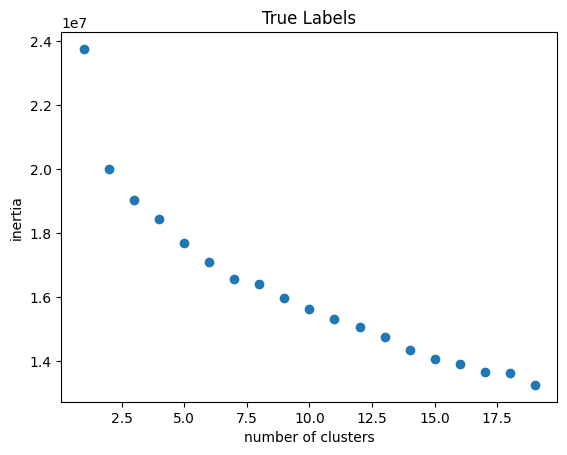

In [ ]:
"""
--- SECTION 3: DFT Dataset Unsupervised Analysis ---
KMeans, PCA, Composition grouping.
"""
#kmeans + PCA analysis to determine a subset of dft bandgaps to sample
X_kmeans = dft_all_ssfp.drop(columns=['gap pbe', 'composition','structure']).fillna(0)
scaler = StandardScaler()
X_scaled_kmeans = scaler.fit_transform(X_kmeans)

#PCA to determine optimal number of components (roughly) graph
X_pca = PCA(n_components=100).fit(X_scaled_kmeans)
c = np.cumsum(X_pca.explained_variance_ratio_)
print(f" Procced with {np.where(c > .90)[0].min()} components")

#proceeding with KMeans clustering with PCA (52 comp)
X_pca = PCA(n_components=52).fit_transform(X_scaled_kmeans)

#KMeans evaluation
inertia = []

for n_clusters in range(1,20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# No clear elbow - so didn't proceed with using PCA in DFT analysis
fig, ax = plt.subplots()
ax.scatter(np.arange(1,20),inertia)
ax.set(xlabel='number of clusters', ylabel='inertia', title="KMeans Inertia from PCA Data")
plt.show()

# **6. Model Improvment (Shuo)**
This architecture is designed based on the isomorphism between Residual Neural Networks (ResNets)
and the iterative Self-Consistent Field (SCF) calculations in Density Functional Theory (DFT).
Instead of treating the regression as a black-box mapping, this model explicitly simulates the
physical process of finding the ground-state electron density and measuring the energy gap.


Design Philosophy & Physical Interpretation
-------------------------------------------
The model consists of three physically meaningful components, mapping the input descriptors to
the target property (Band Gap) through a "Pseudo-SCF" process:

**1. Hamiltonian Proxy Embedding (Initial Guess Construction)**

In DFT, calculations begin with an initial guess of the electron density or wavefunctions
based on the atomic configuration. Similarly, this layer maps the discrete, physics-based
input descriptors (Magpie + Structure) into a high-dimensional continuous latent space.
This latent vector $\mathbf{h}_0$ represents the "effective Hamiltonian" or the initial
quantum state of the material system.
We compute the initial hidden representation as

$$
\mathbf{h}_0 = \mathrm{LayerNorm}\!\left(
\sigma\!\left(\mathbf{W}_{\mathrm{enc}} \mathbf{x} + \mathbf{b}_{\mathrm{enc}}\right)
\right),
$$

where $\mathbf{x}$ are the input features and $\sigma$ is the SiLU activation.

**2. Pseudo-SCF Residual Blocks (Electronic State Relaxation):**

The core of the model mimics the iterative diagonalization or density mixing steps in SCF cycles.

In SCF, the electron density $n(\mathbf{r})$ is updated iteratively to minimize the total energy functional:
$n_{k+1} = n_k + \alpha (n_{new} - n_k)$.
       
This is mathematically equivalent to the residual update rule in ResNets. Each residual block
represents a "virtual time step" in the relaxation process, allowing the latent state vectors
to evolve towards the ground state representation. The depth of the network corresponds to the
complexity of the many-body interactions (exchange-correlation effects) being modeled.

$\mathbf{h}_{k+1} = \mathbf{h}_k + \mathcal{F}(\mathbf{h}_k; \theta_k)\$

where $\mathcal{F}$ represents the non-linear transformation (interaction corrections) applied
at step $k$.

Physical Readout Head (Observable Measurement):
Once the latent state has "converged" to the final representation $\mathbf{h}_L$ (approximating
the ground state density), the model projects this state onto the scalar observable (Band Gap).
       
Crucially, we enforce the physical constraint of non-negativity. Unlike standard linear outputs
or ReLU (which suffers from "dying" gradients), we use the Softplus activation function. This
smoothly enforces $E_g \ge 0$ and models the metal-semiconductor transition (where $E_g \to 0$)
as a continuous physical process rather than a hard cutoff.

$$
\hat{E}_g = \text{Softplus}(\mathbf{w}_{out}^T \mathbf{h}_L + b_{out}) = \ln(1 + \exp(\mathbf{w}_{out}^T \mathbf{h}_L + b_{out}))\
$$

In [ ]:
class ResidualSCFBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )

    def forward(self, x):
        return x + self.net(x)

class PhysicsResNet(nn.Module):
    def __init__(self, input_dim, embed_dim=128, num_blocks=3):
        super().__init__()
        self.num_blocks = num_blocks

        self.physics_encoder = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.SiLU()
        )

        self.shared_block = ResidualSCFBlock(embed_dim)

        self.head = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
            nn.Softplus()
        )

    def forward(self, x):
        h = self.physics_encoder(x)

        for _ in range(self.num_blocks):
            h = self.shared_block(h)

        return self.head(h)

IMPORTANT_FEATURES = [
    'MagpieData maximum MendeleevNumber', 'MagpieData mean AtomicWeight',
    'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT',
    'MagpieData mean MeltingT', 'MagpieData minimum Column',
    'MagpieData range Column', 'MagpieData avg_dev Column',
    'MagpieData mode Column', 'MagpieData range Row', 'MagpieData mean Row',
    'MagpieData range Electronegativity', 'MagpieData avg_dev Electronegativity',
    'MagpieData mode Electronegativity', 'MagpieData mean NpValence',
    'MagpieData maximum NdValence', 'MagpieData range NdValence',
    'MagpieData mean NdValence', 'MagpieData maximum NfValence',
    'MagpieData mean NfValence', 'MagpieData mean NValence',
    'MagpieData mode NValence', 'MagpieData maximum NpUnfilled',
    'MagpieData range NpUnfilled', 'MagpieData mean NpUnfilled',
    'MagpieData range NUnfilled', 'MagpieData mean NUnfilled',
    'MagpieData mode NUnfilled', 'MagpieData minimum GSvolume_pa',
    'MagpieData mode GSvolume_pa', 'MagpieData maximum GSbandgap',
    'MagpieData range GSbandgap', 'MagpieData mode GSbandgap',
    'MagpieData mean GSmagmom', 'MagpieData mode SpaceGroupNumber'
]

def prepare_data(csv_path):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        print("CSV not found, creating dummy data.")
        data = np.random.rand(200, len(IMPORTANT_FEATURES))
        df = pd.DataFrame(data, columns=IMPORTANT_FEATURES)
        df['gap expt'] = np.random.exponential(scale=1.5, size=200)
        df.loc[:40, 'gap expt'] = 0.0

    available_feats = [c for c in IMPORTANT_FEATURES if c in df.columns]
    X = df[available_feats].values
    y = df['gap expt'].values.reshape(-1, 1)

    return X, y

def train_physical_resnet():
    X, y = prepare_data('team-a.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler_x = StandardScaler()
    X_train = scaler_x.fit_transform(X_train)
    X_test = scaler_x.transform(X_test)

    y_scale_factor = 5.0
    y_train_scaled = y_train / y_scale_factor

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train_scaled, dtype=torch.float32))
    test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    model = PhysicsResNet(input_dim=X.shape[1], embed_dim=128, num_blocks=3).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    criterion = nn.HuberLoss(delta=1.0)

    print("Training PhysicsResNet...")
    for epoch in range(300):
        model.train()
        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            pred = model(bx)
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for bx, by_raw in test_loader:
            bx = bx.to(DEVICE)
            pred_scaled = model(bx)
            pred_raw = pred_scaled.cpu().numpy() * y_scale_factor

            preds.append(pred_raw)
            targets.append(by_raw.numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    print(f"MAE: {np.mean(np.abs(preds - targets)):.4f}")

In [ ]:
train_physical_resnet()